### Imports

In [ ]:
#!pip install gymnasium stable-baselines3[extra] moviepy
#!pip install sb3-contrib

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.callbacks import BaseCallback
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pathlib
from sb3_contrib import RecurrentPPO
from IPython.display import clear_output, display, HTML
import imageio.v2 as imageio
import base64
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordEpisodeStatistics as Monitor

# PPO Algorithm

### Custom Callback

In [ ]:
# Custom Callback class for saving rewards and episode lengths
class EpisodeLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_lengths = []

    # Access the environment's info for the current step
    def _on_step(self) -> bool:
        if "episode" in self.locals["infos"][0]:
            episode_info = self.locals["infos"][0]["episode"]
            self.episode_rewards.append(episode_info["r"])
            self.episode_lengths.append(episode_info["l"])
        return True

Here I create a custom callback class. I use it to log the whole training episode metrics (rewards and lengths) and not only for the last 100 that is set as default in SB3. I use this for monitoring and analysis of training progress by collecting performance metrics during the agent's interaction with the environment.

## Model Training and Analysis

Proximal Policy Optimization (PPO) is a policy gradient method that improves traditional actor‐critic methods by “clipping” policy updates. Instead of allowing the new policy to change drastically from the old one in a single update, PPO restricts the change to a small, safe range. This helps keep learning stable and prevents the agent from taking leaps in policy space. So PPO is a more stable policy gradient algorithm.

Here I initialise the PPO algorithm with the Stable-Baselines3 default hyperparameters, and I use the "MlpPolicy" that utilises 2 multi-layer perceptron (MLP) forward networks, one to parametrise policy updates and one for the value updates.

---

### Policy Network (Actor):

$
\pi_\theta(a|s) = \mathcal{N}(\mu_\theta(s), \sigma_\theta(s)^2)
$

This one determines the actions the agent should take based on the current state and updates the policy. (Continuous Action Space)

---

### Value Network (Critic):

$V_\phi(s) = f_\phi(s)$

This one calculates the value function $V_\phi(s)$, the expected cumulative reward from a given state. Helps to calculate the advantage function $A_t$, which evaluates how good an action is compared to the expected value.

---

### Advantage Function with Temporal Difference (TD) Error:

The advantage function is approximated using the TD error:

$
A_t = r_t + \gamma V(s_{t+1}) - V(s_t)
$

The TD error quantifies the difference between the predicted value and the observed value. PPO uses this advantage function within the clipped surrogate objective to stabilize policy updates and prevent excessively large changes.

---

### Generalized Advantage Estimation (GAE)

$
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots + (\gamma \lambda)^{T-t+1} \delta_{T-1},
$

$
\text{where } \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t).
$

With GAE, the algorithm computes the advantage function $A_t$ by weighting temporal difference (TD) errors across multiple future steps. GAE helps the algorithm to stabilize the training and be more efficient.

---

Both MLPs have the default structure:

- **2 hidden layers** with **64 neurones** each.
- **Tanh** Activation function for hidden layers.
- **Adam** optimiser.

---

### The Policy and Value Networks in PPO :

The **Actor** updates the policy to maximize the clipped surrogate objective, which incorporates the advantage ensuring stable updates.

The **Critic** minimizes the value loss by reducing the squared difference between the targeted value and the observed returns.

### Total Time Steps Analysis

Here I will test how the agent trains and interacts with the environment for 2 different timestep values: 40k and 100k.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
timesteps = [40_000, 100_000]
all_rewards = []
trial_rew_mean = []


for timestep in timesteps:

  #Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {timestep} timesteps")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=False,                                                  # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=timestep, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 40000 timesteps
All episodes: 41

Training with 100000 timesteps
All episodes: 100
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

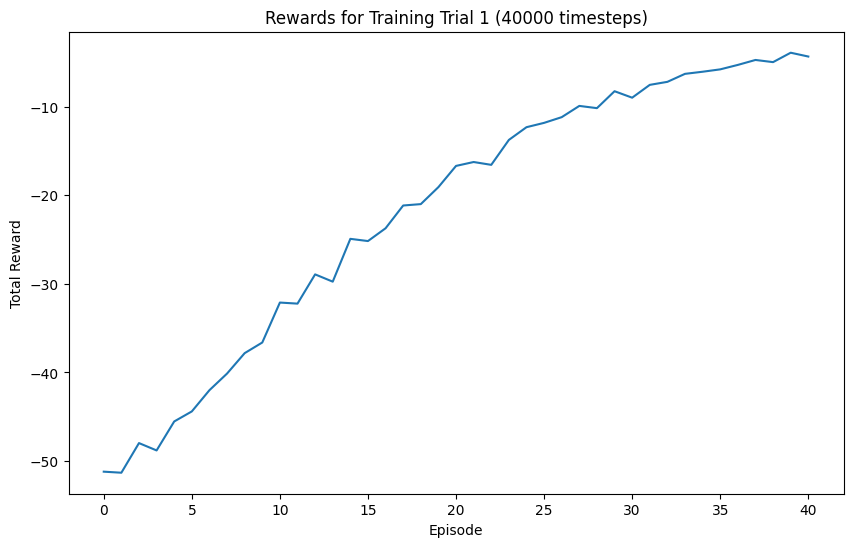

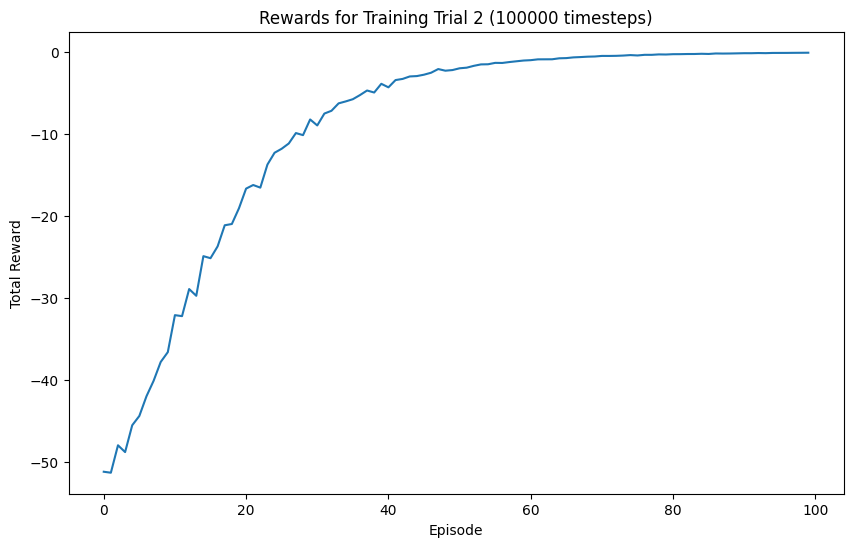

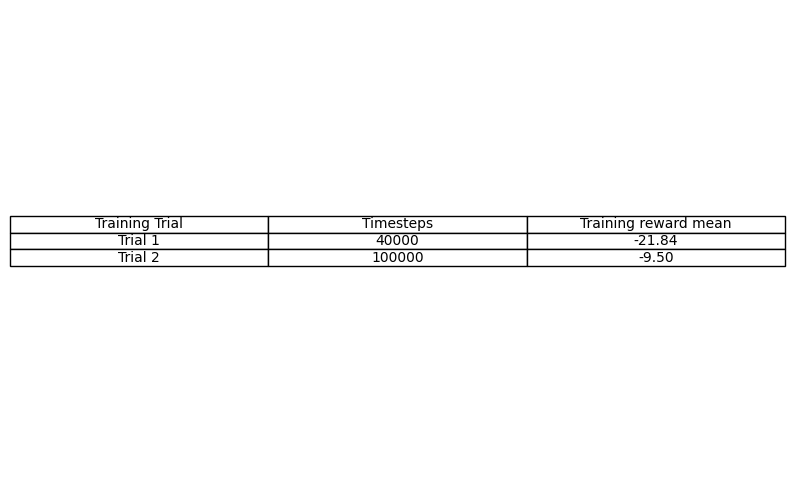

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({timesteps[i]} timesteps)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", timesteps[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Timesteps", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
These graphs represent the total rewards per episode over the training period. The x-axis shows the episode number, and the y-axis shows the cumulative reward for each episode. At first we see that the algorithm is improving, as the rewards increase from -50 toward 0. However, for both 40k and 100k total timesteps, the rewards stabilise around 0 and do not exceed this value, showing that the agent has plateaued and is not learning the optimal policy. That happens because it tries to maximize the reward only with small moves back and forth, making it stuck at 0, never reaching the goal of +100 reward. This possibly happens because the agent doesn't explore enough and reaches the reward sparsely.

C:\Users\wowac\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



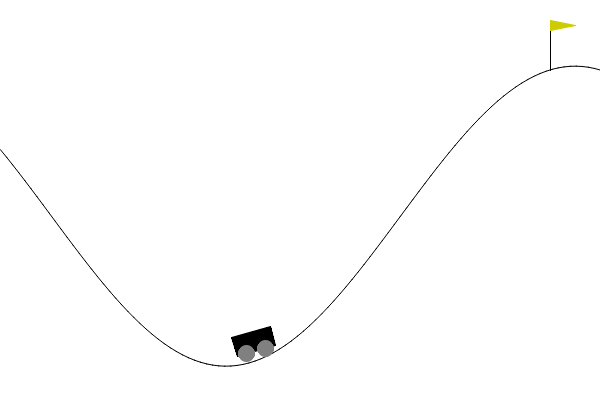

In [ ]:
# Load the trained model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
model = PPO.load("PPO_MLP")
frames = []

# Test the model and save frames
obs, info = env.reset()
terminated, truncated = False, False

while not (terminated or truncated):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame)

env.close()

# Save the frames as a GIF
gif_filename = "mountain_car_simulation.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Display the GIF
with open(gif_filename, 'rb') as f:
    data = f.read()
    b64_data = base64.b64encode(data).decode('utf-8')
    display(HTML(f'<img src="data:image/gif;base64,{b64_data}" width="600">'))


### State-Dependent Exploration Analysis

The SDE parameter controls whether the state-dependent exploration mechanism is used during training.

When set to False, the default exploration strategy is used (independent Gaussian noise). Computationally cheaper and sufficient for standard tasks.

When set to True, SDE replaces the standard noise in the policy with state-dependent noise, allowing for more structured and adaptive exploration based on the state, better for continuous action space but computationally expensive. The noise is sampled once in the start of a rollout. For testing this hyperparameter, I will use 100k total timesteps.

- $
\pi_\theta(a \mid s) = \mathcal{N}(\mu_\theta(s), \sigma_s^2)
$: The action $a$ is sampled from a Gaussian distribution with mean $\mu_\theta(s)$ and state-dependent variance $\sigma_s^2$.


- $
a_t = \mu(s_t, \theta_\mu) + \epsilon(s_t, \theta_\epsilon)
$: The action $a_t$ is the sum of the deterministic policy and the state-dependent noise.

- $
\epsilon(s_t, \theta_\epsilon) = \theta_\epsilon \cdot s_t
$: The state-dependent noise is a linear transformation of the state $s_t$.

- $
\theta_\epsilon \sim \mathcal{N}(0, \sigma^2)
$


In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
sdes = [False, True]
all_rewards = []
trial_rew_mean = []


for sde in sdes:

  # Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with SDE {sde}")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=sde,                                                    # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with SDE False
All episodes: 100

Training with SDE True
All episodes: 289
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

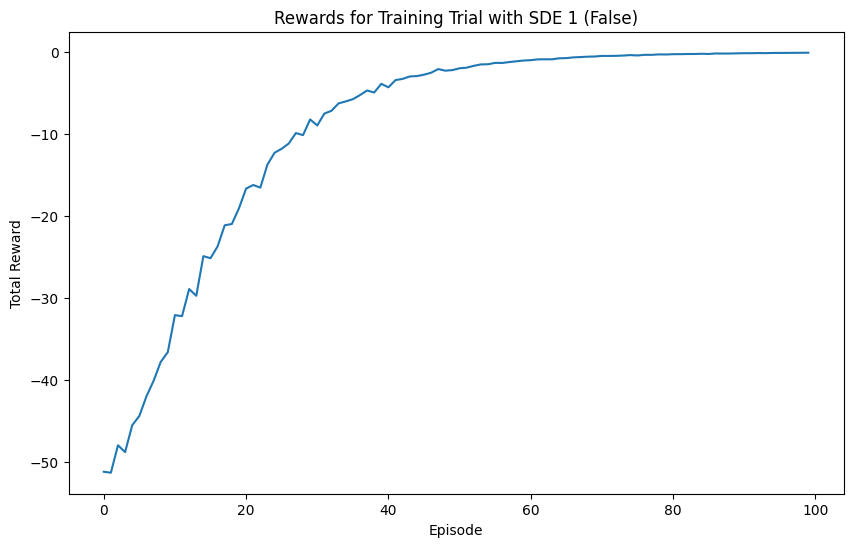

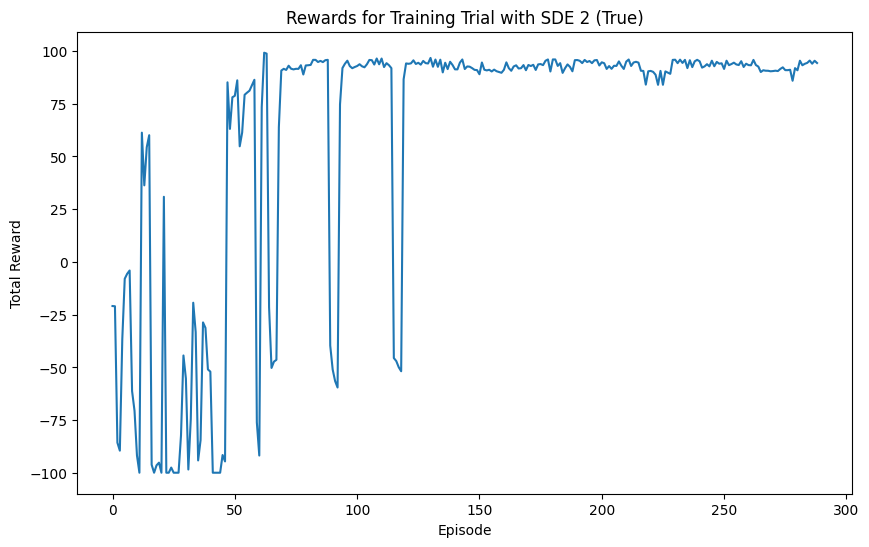

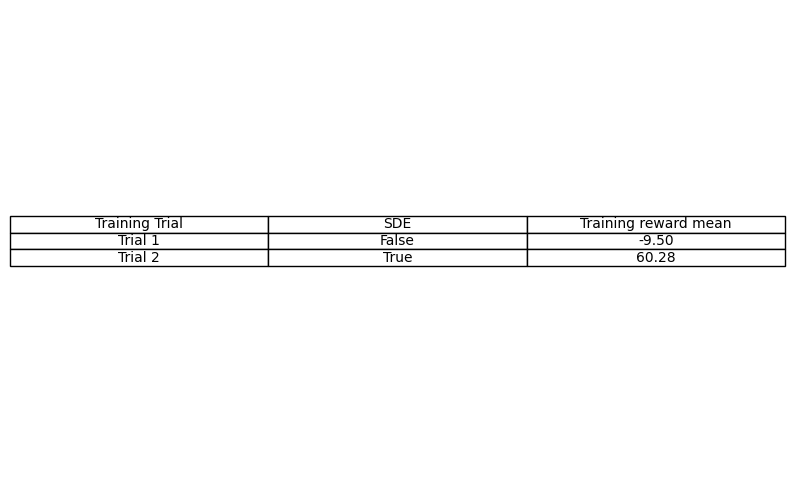

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial with SDE {i+1} ({sdes[i]})")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", sdes[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "SDE", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
In the first plot without the SDE mechanism, the training is stable, but the agent won't explore enough, as we saw in earlier experiments, so the agent fails to learn the optimal policy and stabilizes near 0. In the second graph with SDE, the agent seems to explore the environment better and improve in general. After episode 125, the algorithm seems to converge with a training reward mean at 60.28.

### Entropy Coefficient Analysis

The (entropy coefficient) c2 controls the weight of the entropy term in the PPO loss function. Entropy measures the randomness in the agent's action distribution. Adding an entropy bonus will make the agent explore more by preventing the policy from becoming too deterministic early in training. For testing this hyperparameter, I will use 100k total timesteps.

**Full Objective Function:**

$
L^{\text{CLIP+VF+S}}_t(\theta) = \widehat{\mathbb{E}}_t \left[ L^{\text{CLIP}}_t(\theta) - c_1 L^{\text{VF}}_t(\theta) + c_2 S[\pi_\theta](s_t) \right]
$

- $
L^{\text{CLIP}}(\theta) = \widehat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \widehat{A}_t, \text{clip}\left(r_t(\theta), 1-\epsilon, 1+\epsilon \right) \widehat{A}_t \right) \right]
$

- $
L^{\text{VF}}_t(\theta) = \left( V_\theta(s_t) - V^{\text{target}}_t \right)^2
$

- $
S[\pi_\theta](s_t) = \frac{1}{2} \log(2\pi e \sigma^2)
$



In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
ent_coefs = [1e-3, 1e-2, 1e-1]
all_rewards = []
trial_rew_mean = []


for ent_coef in ent_coefs:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ent_coef} Entropy coefficient")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-4,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=ent_coef,                                              # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 0.001 Entropy coefficient
All episodes: 129

Training with 0.01 Entropy coefficient
All episodes: 149

Training with 0.1 Entropy coefficient
All episodes: 219
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

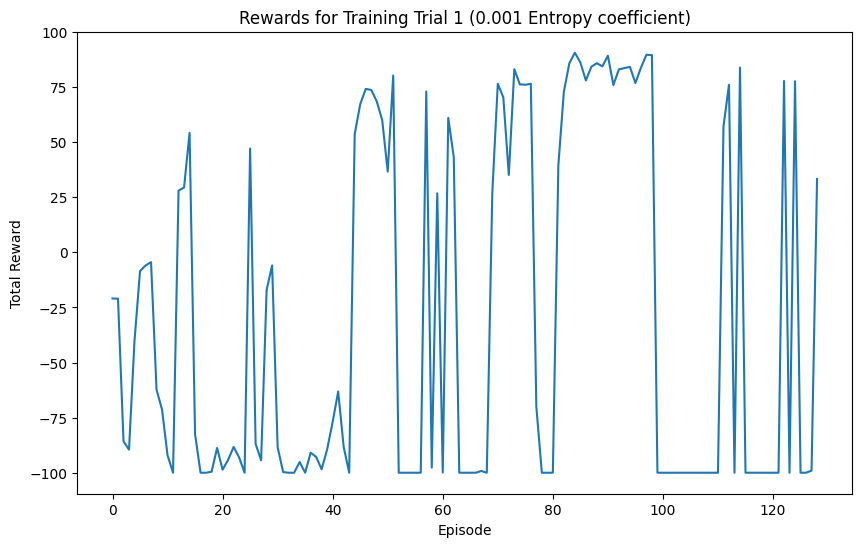

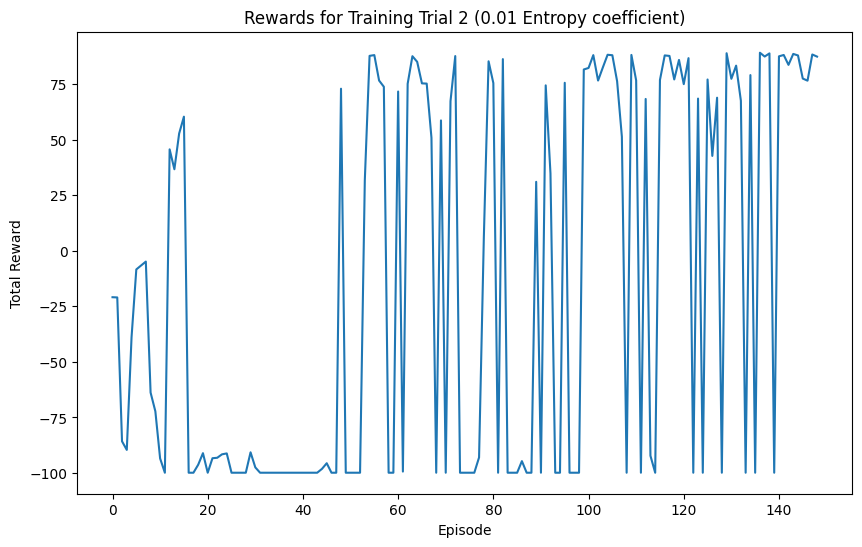

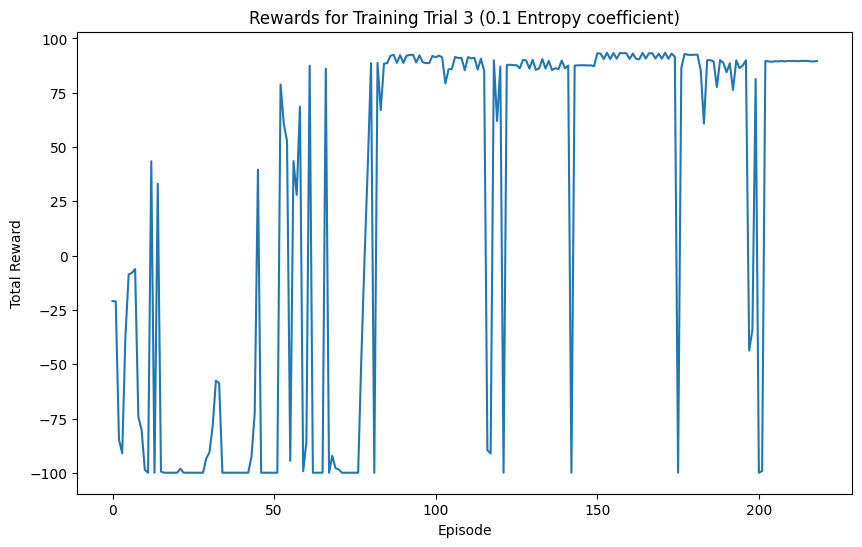

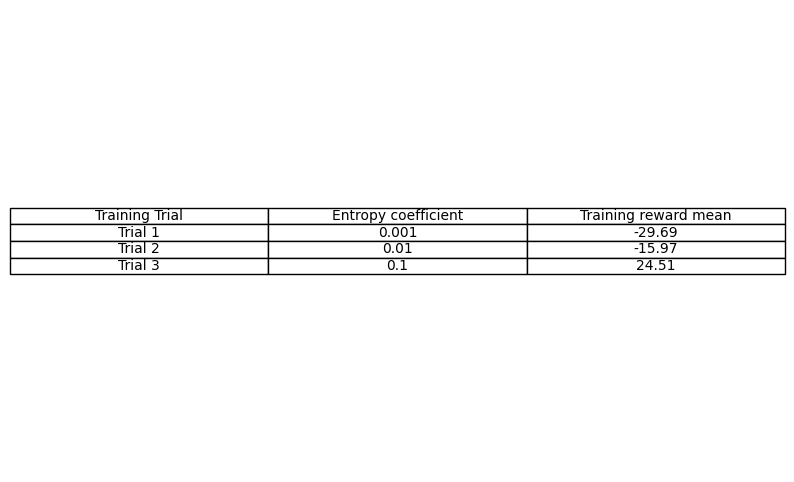

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ent_coefs[i]} Entropy coefficient)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ent_coefs[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Entropy coefficient", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
These graphs show the training process with different entropy coefficients. For a low entropy coefficient of 0.001, the agent struggles to explore effectively and fluctuates a lot, leading to less consistent improvement, and it's not converging. As the entropy coefficient increases by 0.01, the agent explores the environment more, having more high rewards with a lot of fluctuation. For a high entropy coefficient of 0.1, the agent continues to favour exploration and cannot find an optimal policy. These experiments show that while exploration increases, stability gets reduced.

### Learning Rate Analysis

The learning rate is a hyperparameter that controls the step size of the gradient updates for both the policy and value networks, which share the same optimizer. By default, SB3's PPO uses the Adam optimizer with a learning rate of 3e-4, which balances convergence speed and stability for most tasks. For testing this hyperparameter, I will use 100k total timesteps.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
ln_rates = [3e-5, 3e-4, 3e-3]
all_rewards = []
trial_rew_mean = []


for ln_rate in ln_rates:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ln_rate} Learning Rate")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=ln_rate,                                          # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.01,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 3e-05 Learning Rate
All episodes: 111

Training with 0.0003 Learning Rate
All episodes: 149

Training with 0.003 Learning Rate
All episodes: 682
Model PPO_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

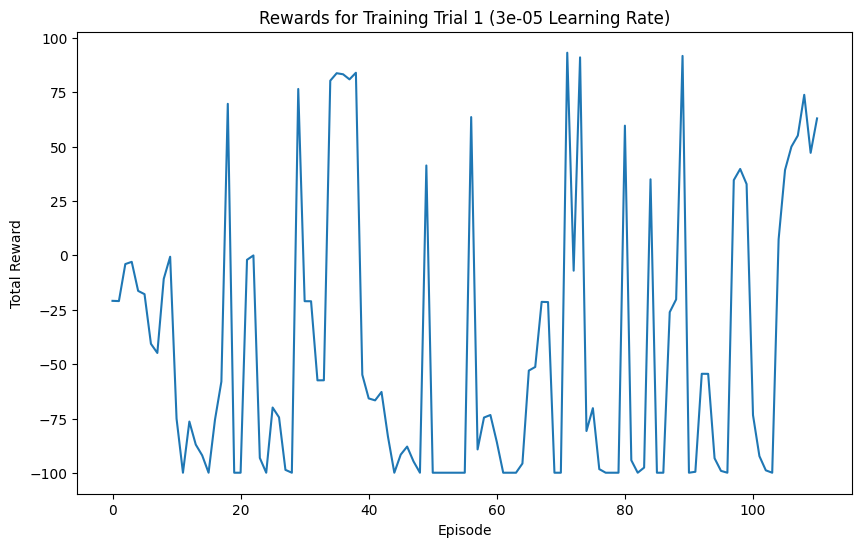

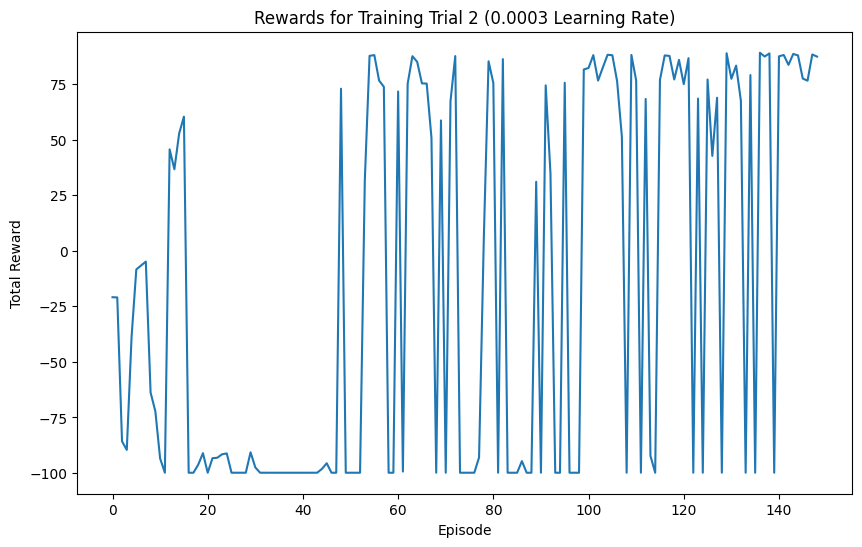

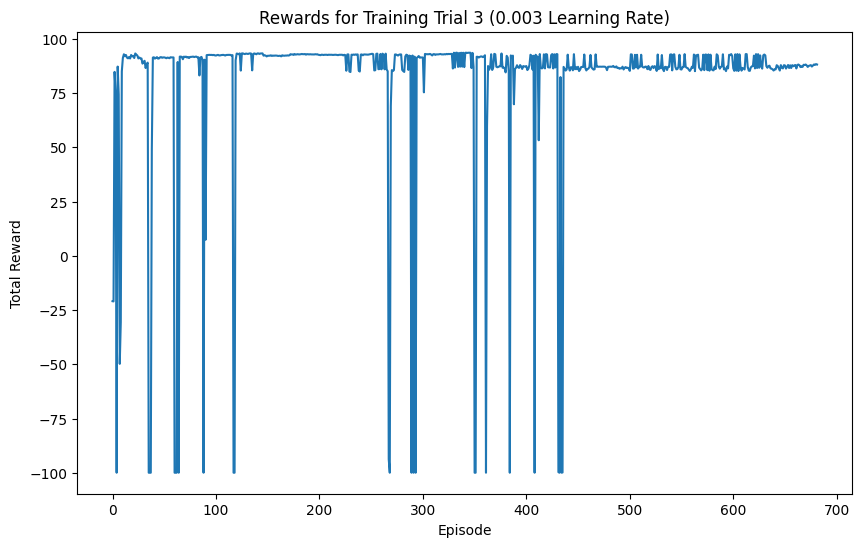

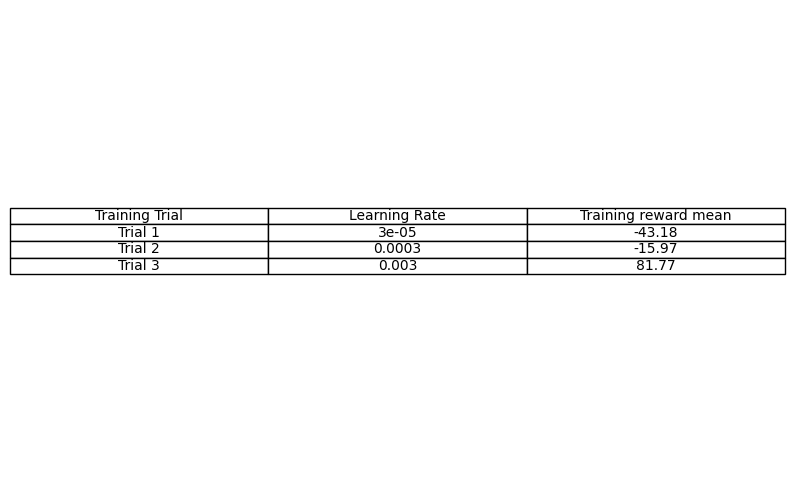

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ln_rates[i]} Learning Rate)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ln_rates[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Learning Rate", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
In this experiment, we see that with a smaller learning rate, the algorithm can't converge or even stabilise to an optimal policy, having a negative reward mean. The faster learning rate shows great results with an 81.77 reward mean and looks like the algorithm is converging in an optimal policy. Also, with bigger learning rates, the optimiser makes larger parameter updates, making the agent learn the optimal policy faster, terminating each episode sooner. This explains the different values of total episodes with each training trial.


### Maximum Gradient Clipping Analysis

During training, gradients are computed for each parameter in the networks, and if their total norm exceeds the threshold (max_grad_norm), they are scaled down proportionally to match the threshold. This prevents large updates, stabilizing training and avoiding exploding gradients. A smaller Maximum Gradient Clipping restricts updates more aggressively, improving stability but slowing convergence, while a larger one allows faster convergence but risks instability if the gradients become too large.

The gradients for all parameters

- $
g = [g_1, g_2, \dots, g_n]
$


The norm of the gradients is calculated as:

- $
\|g\|_2 = \sqrt{\sum_{i=1}^n g_i^2}
$


If
- $
\|g\|_2 > \text{max_grad_norm}
$

The gradients are scaled as:

- $
g_i' = g_i \cdot \frac{\text{max_grad_norm}}{\|g\|_2}
$

This ensures the new gradient norm satisfies:

- $
\|g'\|_2 = \text{max_grad_norm}
$

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
max_grad_norms = [0.4, 0.5, 0.6, 0.65, 0.7]
all_rewards = []
trial_rew_mean = []


for max_grad_norm in max_grad_norms:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {max_grad_norm} Maximum Gradient Clipping")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-3,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.01,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=max_grad_norm,                                    # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=42,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with 0.4 Maximum Gradient Clipping
All episodes: 441

Training with 0.5 Maximum Gradient Clipping
All episodes: 682

Training with 0.6 Maximum Gradient Clipping
All episodes: 625

Training with 0.65 Maximum Gradient Clipping
All episodes: 1099

Training with 0.7 Maximum Gradient Clipping
All episodes: 242
Model PPO_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

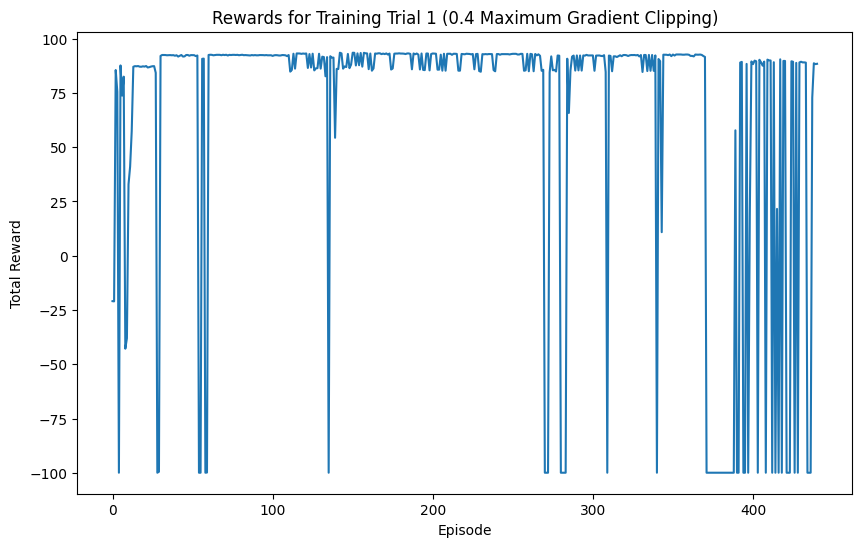

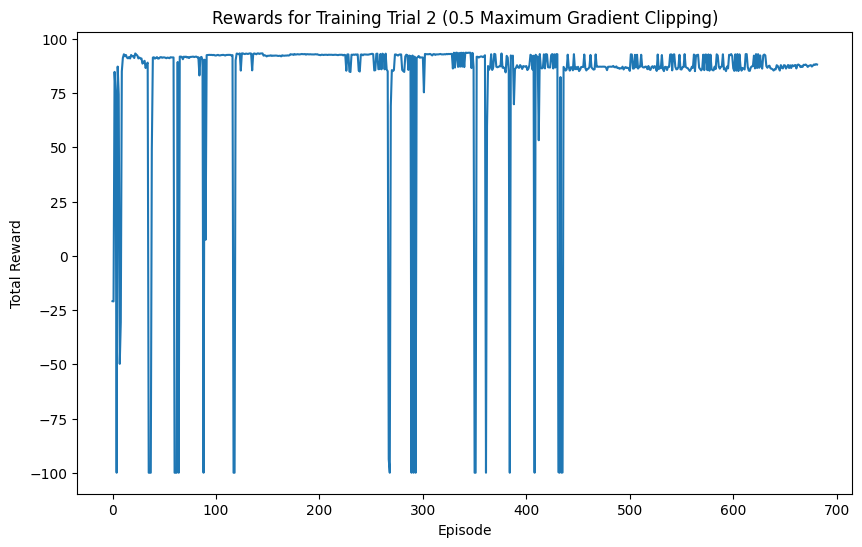

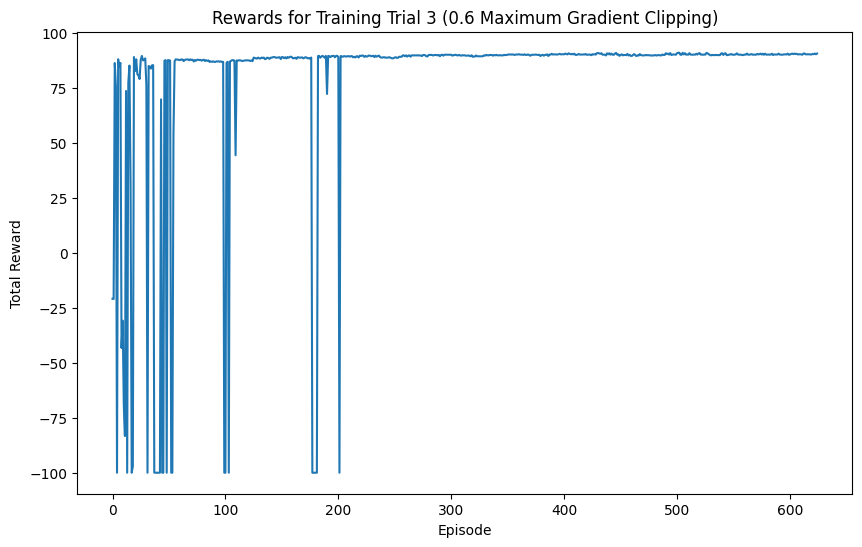

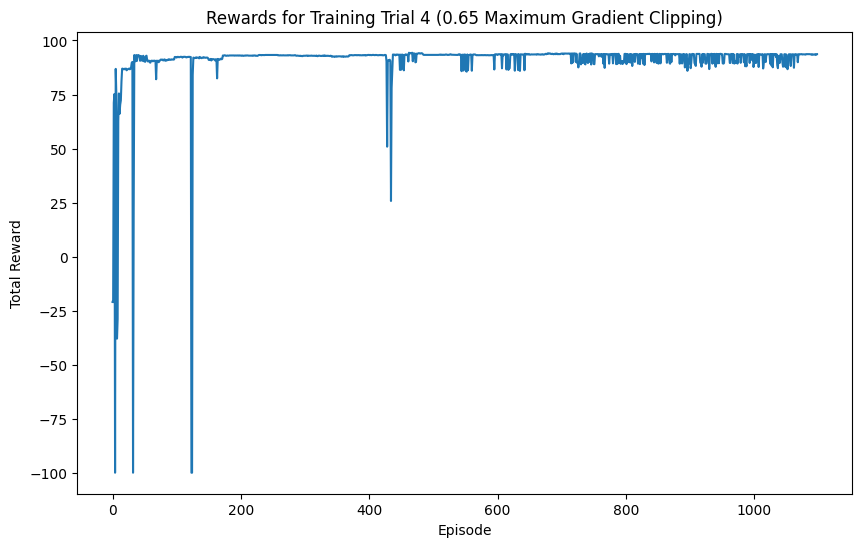

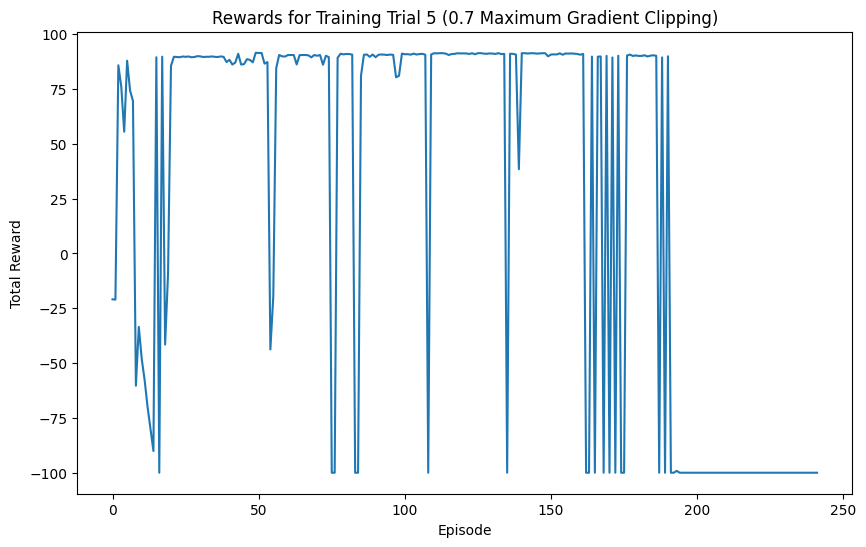

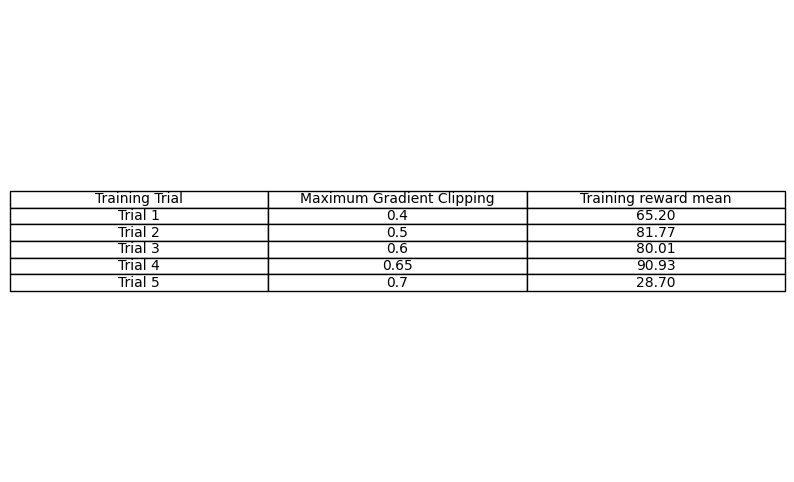

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({max_grad_norms[i]} Maximum Gradient Clipping)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", max_grad_norms[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Maximum Gradient Clipping", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
The graphs show that a small gradient clipping value is unstable. Around the default value (0.5-0.6) the algorithm is more stable and converges ~80 training reward mean. With higher value (0.65) the algorithm is not so stable, but converges faster, so it accumulates more positive rewards close to the 90 training reward mean. Bigger values than 0.65 destabilise the algorithm, making it fluctuate too much and in a wider range, so preventing it from a good converging point.

### Seeding

Here I will test the algorithm with different seeds to showcase the importance of seeding. Seeding controls the initialization of randomness in training processes, ensuring reproducibility by fixing the random number generators for neural network weights, environment dynamics, and exploration noise.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
seeds = [0, 5, 10, 25, 42, 50]
all_rewards = []
trial_rew_mean = []


for seed in seeds:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with Seed={seed} ")

  model = PPO(
      "MlpPolicy",
      env,
      learning_rate=3e-3,                                             # Change the learning rate
      n_steps=2048,                                                   # Steps per rollout
      batch_size=64,                                                  # Minibatch size
      n_epochs=10,                                                    # Optimization epochs per update
      gamma=0.99,                                                     # Discount factor
      clip_range=0.2,                                                 # Clipping range
      ent_coef=0.01,                                                  # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.6,                                              # Gradient clipping
      gae_lambda=0.95,                                                # GAE lambda
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=seed,                                                      # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this trial
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("PPO_MLP")
env.close()
print("Model PPO_MLP saved successfully.")


Training with Seed=0 
All episodes: 177

Training with Seed=5 
All episodes: 176

Training with Seed=10 
All episodes: 345

Training with Seed=25 
All episodes: 147

Training with Seed=42 
All episodes: 625

Training with Seed=50 
All episodes: 139
Model PPO_MLP saved successfully.


#### Total Rewards Plot


<Figure size 1000x600 with 0 Axes>

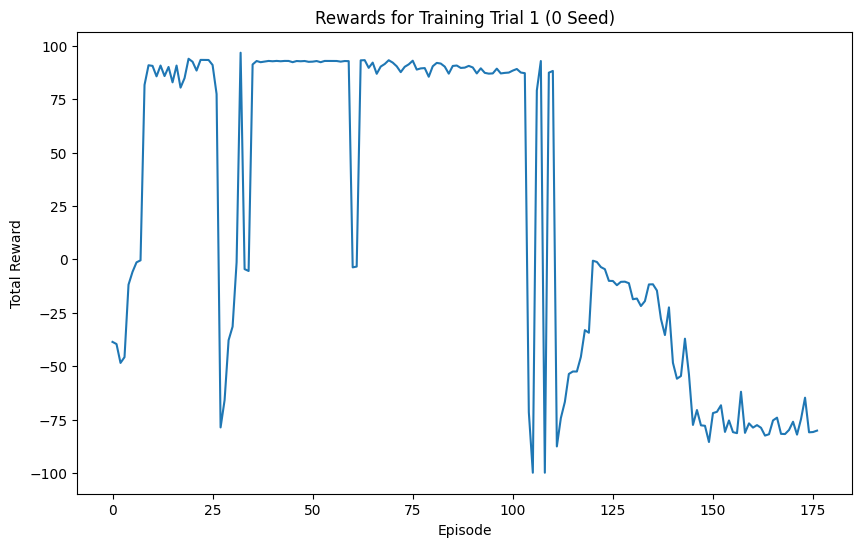

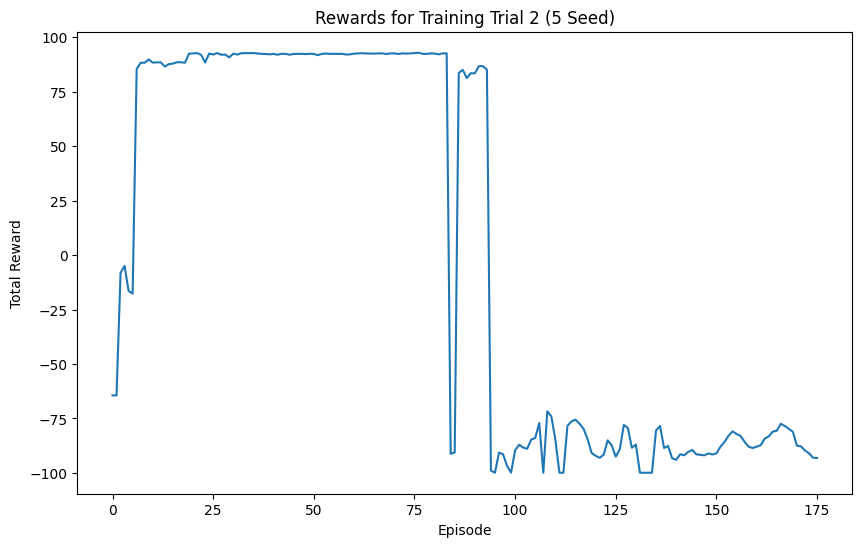

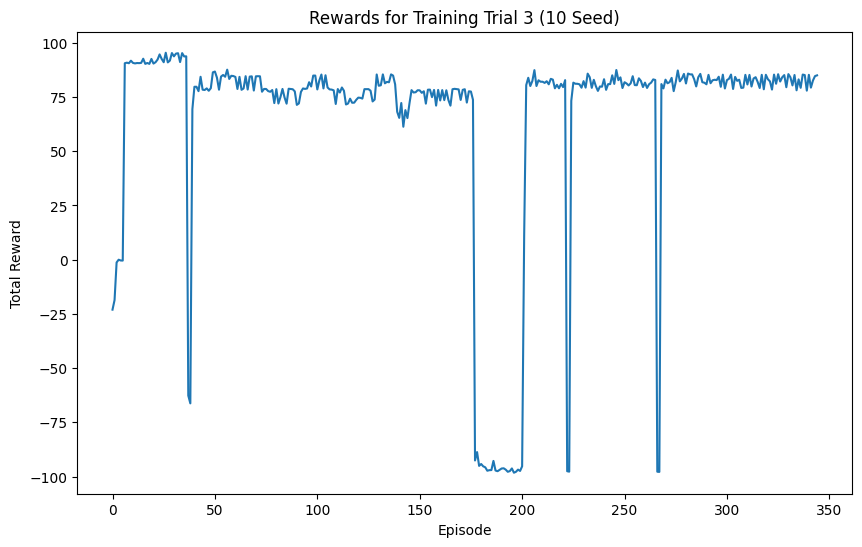

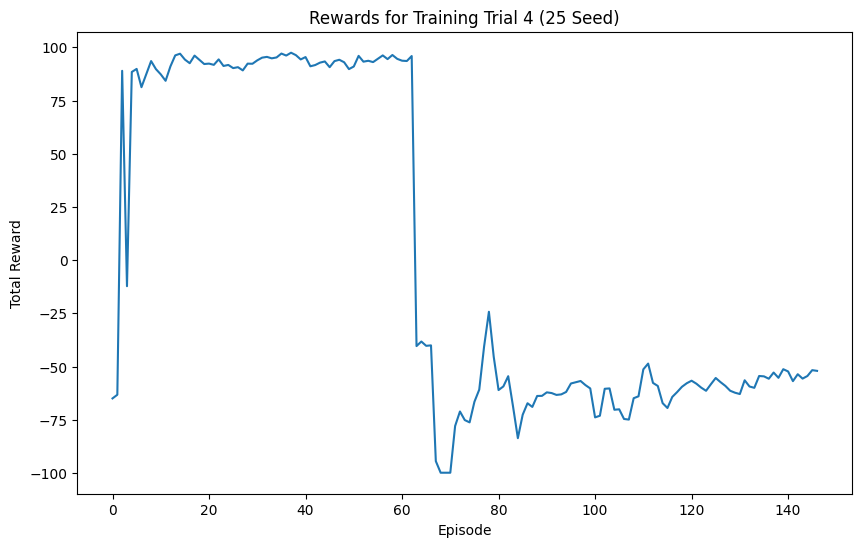

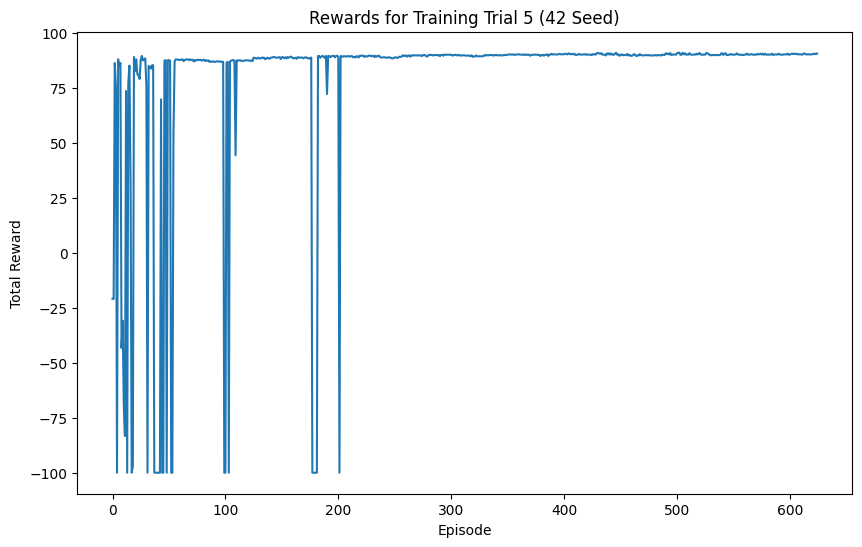

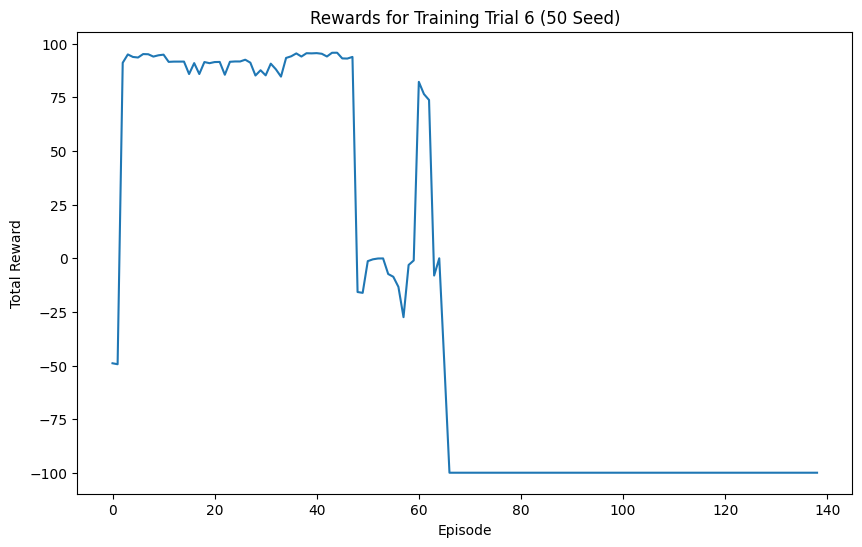

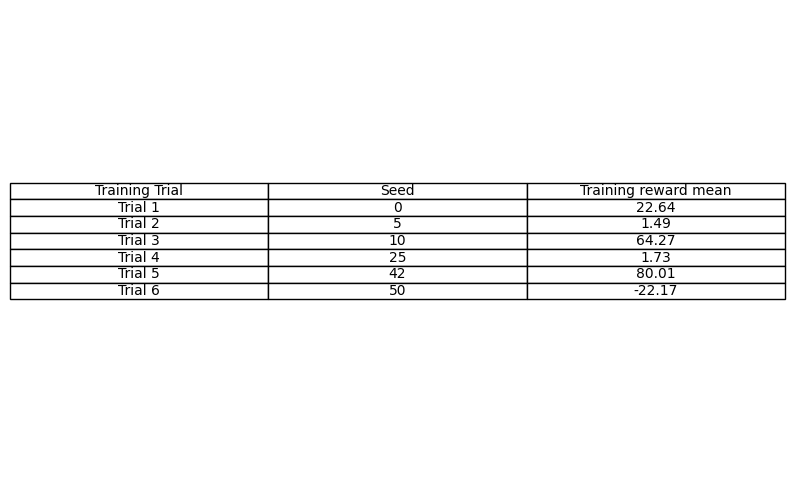

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({seeds[i]} Seed)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", seeds[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Seed", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
The training show a lot of variability in performance across different seeds, with Trial 3 (seed=10) and Trial 5 (seed=42) achieving high mean rewards (64.27 and 80.01), while Trials 2, 4, and 6 (seeds=5, 25, 50) show poor or negative mean rewards (-22.17 for seed=50), suggesting high sensitivity to initialization. Reward progression plots show inconsistent learning curves, with some trials like Trial 1 oscillating between negative and positive rewards too much without converging. With that in mind, for the scope of our project, seeding 42 will be used as optimal and seed 50 as the worst.

### Conclusion

In MountainCar continuous, you only get a positive reward when you reach the top, with the PPO algorithm, that means that we will have a sparse reward problem. **PPO is an on-policy algorithm**, it performs a policy gradient update after each episode. Reaching the goal in MountainCar by random actions is a pretty rare event. When it finally happens, it's very unlikely that a single policy gradient update will be enough to start reaching the goal consistently, so PPO gets stuck again with no learning signal until it reaches the goal again by chance.

To counter that, I tested the hyperparameters for a more aggressive exploration and faster learning. A higher entropy coefficient **(ent_coef=0.01)** for more stochastic policies and wider exploration, while state-dependent exploration **(use_sde=True)** adapts exploration noise to different states. Also a higher **learning rate (3e−3)** and larger gradient updates **(max_grad_norm=0.65)**, allowing quicker adaptation to sparse rewards. This increases variance and training fluctuations, enabling the agent to explore more effectively and reduce the problem of sparse reward signal, making the algorithm converge. Also seeding is a very important parameter that shows that random initialization is crucial for the training of the model.


## PPO Optimal Model

I will use the hyperparameters tuned based on the above experiments. For the rest of the hyperparameters, I will use the default values:

- Discount factor $
\gamma = 0.99
$

- Clipping parameter $
\epsilon = 0.2
$

- Value function coefficient $
c_1 = 0.5
$

- GAE $
\lambda = 0.95
$

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()
trial_rew_mean = []

# Create and train the PPO model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
logger_callback.episode_rewards = []


model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-3,                                             # Change the learning rate
    n_steps=2048,                                                   # Steps per rollout
    batch_size=64,                                                  # Minibatch size
    n_epochs=10,                                                    # Optimization epochs per update
    gamma=0.99,                                                     # Discount factor
    clip_range=0.2,                                                 # Clipping range
    ent_coef=0.01,                                                  # Entropy coefficient
    vf_coef=0.5,                                                    # Value function coefficient
    max_grad_norm=0.65,                                             # Gradient clipping
    gae_lambda=0.95,                                                # GAE lambda
    use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
    seed=42,                                                        # Seeding
    verbose=0,                                                      # Verbosity level
    device='cpu'                                                    # Device
)

# Train the model with the callback
model.learn(total_timesteps=40_000, callback=logger_callback)
rewards = logger_callback.episode_rewards

# Compute the ep_rew_mean
ep_rew_mean = np.mean(logger_callback.episode_rewards)
trial_rew_mean.append(ep_rew_mean)

print("All episodes :", len(logger_callback.episode_rewards))
model1_rewards = logger_callback.episode_rewards[:]
model1_mean = np.mean(model1_rewards)


# Save the trained model
model.save("PPO_MLP_Opt1")
env.close()
print("Model PPO_MLP saved successfully.")

All episodes : 369
Model PPO_MLP saved successfully.


#### Total Rewards Plot

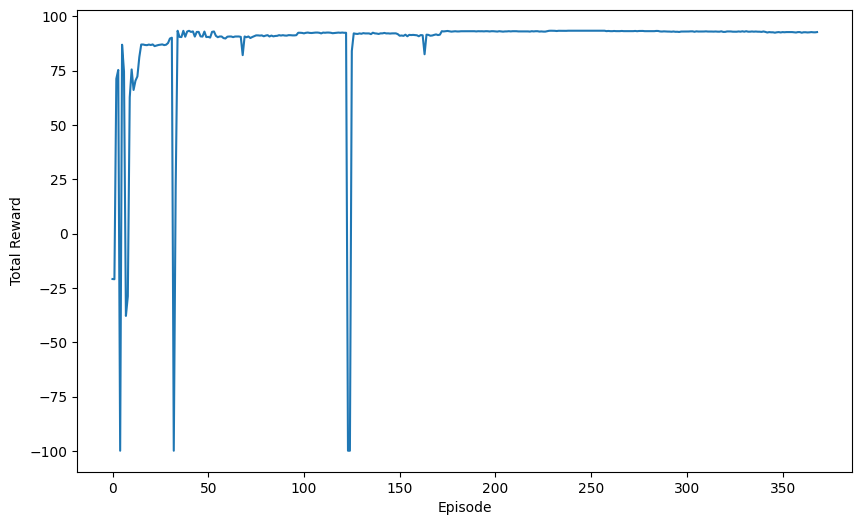

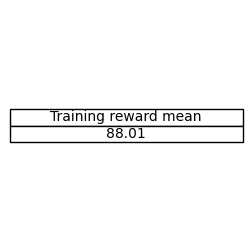

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.table(
    cellText=[[f"{ep_rew_mean:.2f}"]],
    colLabels=["Training reward mean"],loc='center',cellLoc='center'
)
plt.show()

C:\Users\wowac\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(



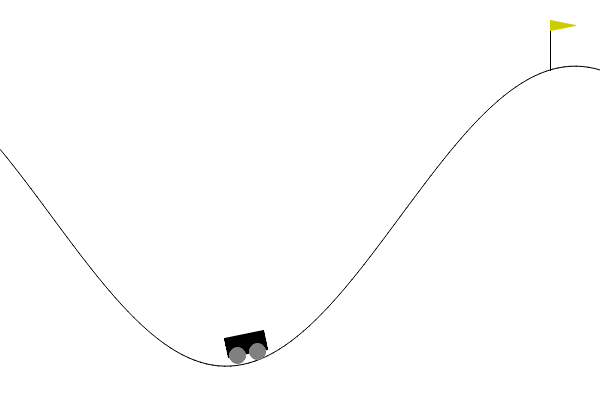

In [ ]:
# Load the trained model
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
model = PPO.load("PPO_MLP_Opt1")
frames = []

# Test the model and save frames
obs, info = env.reset()
terminated, truncated = False, False

while not (terminated or truncated):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame)

env.close()

# Save the frames as a GIF
gif_filename = "mountain_car_simulation.gif"
imageio.mimsave(gif_filename, frames, fps=30, loop=0)

# Display the GIF
with open(gif_filename, 'rb') as f:
    data = f.read()
    b64_data = base64.b64encode(data).decode('utf-8')
    display(HTML(f'<img src="data:image/gif;base64,{b64_data}" width="600">'))


# A2C Algorithm

## Model Training and Analysis

Synchronous Advantage Actor-Critic (A2C) is an actor-critic method where an actor selects actions and a critic estimates the value of each state, updating the policy based on the computed advantage (the difference between the actual return and the expected return). By synchronizing updates across multiple concurrent environments, which leads to more stable and reproducible training compared to asynchronous methods like A3C. However, while its simplicity makes it easier to implement, A2C can be more sensitive to large updates than algorithms like PPO, which incorporate clipping in policy update.

Here I initialize the A2C algorithm with the Stable-Baselines3 default hyperparameters, and I use the "MlpPolicy" that utilizes 2 multi-layer perceptron (MLP) forward networks, one to parameterize policy updates and one for the value updates.

---

### Policy Network (Actor):

$
\pi_\theta(a|s) = \mathcal{N}(\mu_\theta(s), \sigma^2)
$

This network determines the actions the agent should take based on the current state and updates the policy using the advantage function. (Continuous Action Space)

---

### Value Network (Critic):

$
V_\phi(s) = f_\phi(s)
$

This network calculates the value function $V_\phi(s) $, the expected cumulative reward from a given state. It helps compute the advantage function $ A_t $, which measures how much better an action is compared to the expected value.

---

### Advantage Function with Temporal Difference (TD) Error:

The advantage function is approximated using the TD error:

$
\delta_t^{(n)} = (\sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n\ V\bigl(s_{t+n}\bigr)) - V\bigl(s_t\bigr)
$

$
A_t = \delta_t^{(n)}
$

The TD error quantifies the difference between the predicted value and the observed value. A2C uses this advantage function directly to update the policy.

---

### Generalized Advantage Estimation (GAE):
A2C optionally supports GAE for more stable advantage estimation if parameter GAE λ < 1 :

$
\hat{A}_t = \delta_t + (\gamma \lambda) \delta_{t+1} + (\gamma \lambda)^2 \delta_{t+2} + \cdots + (\gamma \lambda)^{T-t+1} \delta_{T-1},
$

$
\text{where } \delta_t = r_t + \gamma V(s_{t+1}) - V(s_t).
$

GAE weights the TD errors across multiple time steps, balancing bias and variance in the advantage estimation, which stabilizes training.

---

### Default MLP Structure:

- **2 hidden layers** with **64 neurons** each.
- **ReLU** Activation function for hidden layers.
- **RMSProp** optimizer.

---

### The Policy and Value Networks in A2C :

1. The **Actor** updates the policy to maximize the expected advantage $ A_t $ by performing gradient ascent.
2. The **Critic** minimizes the TD error by adjusting $ V_\phi(s) $ to align with observed rewards.


### Total Time Steps Analysis

Here I will test how the agent trains and interacts with the environment for 3 different timestep values: 40k, 100k and 200k.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
timesteps = [40_000, 100_000, 200_000]
all_rewards = []
trial_rew_mean = []


for timestep in timesteps:

  #Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {timestep} timesteps")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=7e-4,                                             # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=1,                                                   # GAE lambda
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      rms_prop_eps=1e-05,                                             # RMSProp epsilon
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=False,                                                  # Use generalized State Dependent Exploration (gSDE)
      seed=0,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=timestep, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with 40000 timesteps
All episodes: 10

Training with 100000 timesteps
All episodes: 25

Training with 200000 timesteps
All episodes: 50
Model A2C_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

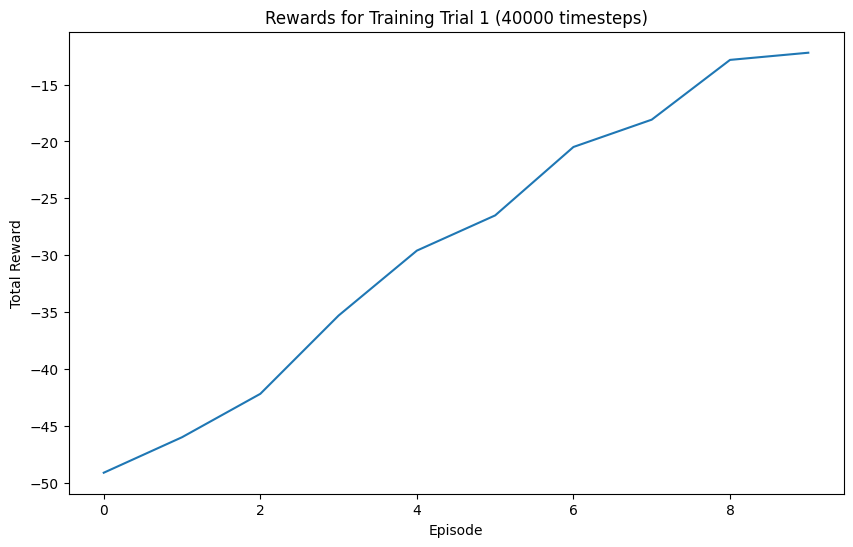

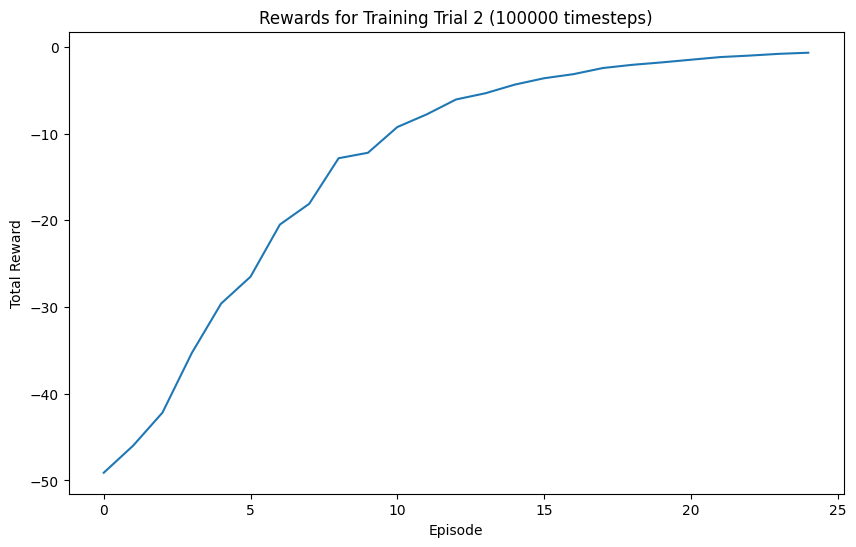

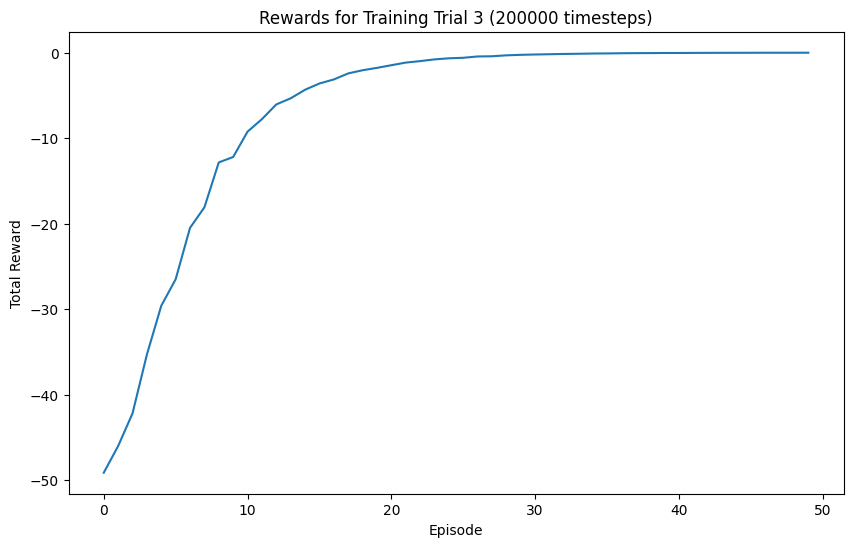

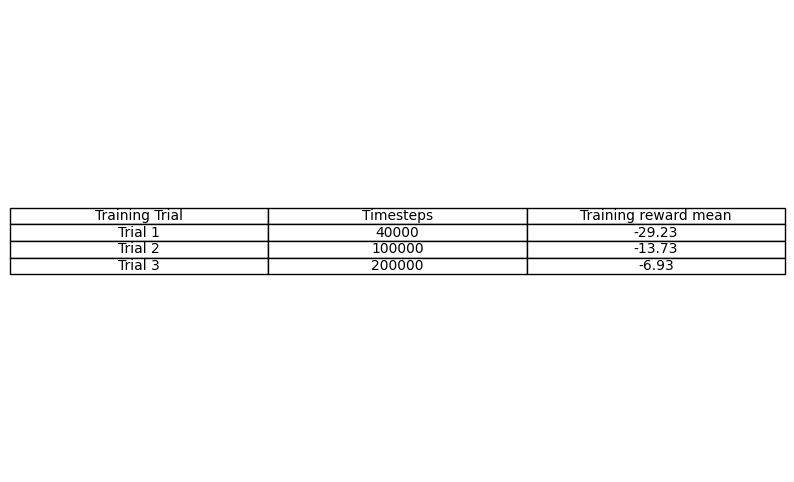

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({timesteps[i]} timesteps)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", timesteps[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Timesteps", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
Like the PPO algorithm, we see that the A2C algorithm is improving, as the rewards increase from -50 to 0. However, for all trials the rewards stabilise around 0 and do not exceed this value, showing that the agent has plateaued and is not learning the optimal policy. That happens because it tries to maximize the reward only with small moves back and forth, making it stuck at 0, never reaching the goal of +100 reward. The same behavior as PPO.

### State-Dependent Exploration Analysis

The SDE parameter controls whether the state-dependent exploration mechanism is used during training.

When set to False, the default exploration strategy is used (independent Gaussian noise). Computationally cheaper and sufficient for standard tasks.

When set to True, SDE replaces the standard noise in the policy with state-dependent noise, allowing for more structured and adaptive exploration based on the state, better for continuous action space but computationally expensive. The noise is sampled once in the start of a rollout. For testing this hyperparameter, I will use 100k total timesteps.

- $
\pi_\theta(a \mid s) = \mathcal{N}(\mu_\theta(s), \sigma_s^2)
$: The action $a$ is sampled from a Gaussian distribution with mean $\mu_\theta(s)$ and state-dependent variance $\sigma_s^2$.


- $
a_t = \mu(s_t, \theta_\mu) + \epsilon(s_t, \theta_\epsilon)
$: The action $a_t$ is the sum of the deterministic policy and the state-dependent noise.

- $
\epsilon(s_t, \theta_\epsilon) = \theta_\epsilon \cdot s_t
$: The state-dependent noise is a linear transformation of the state $s_t$.

- $
\theta_\epsilon \sim \mathcal{N}(0, \sigma^2)
$

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
sdes = [False, True]
all_rewards = []
trial_rew_mean = []


for sde in sdes:

  #Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with SDE {sde}")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=7e-4,                                             # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=1,                                                   # GAE lambda
      ent_coef=0.0,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      rms_prop_eps=1e-05,                                             # RMSProp epsilon
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=sde,                                                    # Use generalized State Dependent Exploration (gSDE)
      seed=0,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with SDE False
All episodes: 25

Training with SDE True
All episodes: 56
Model A2C_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

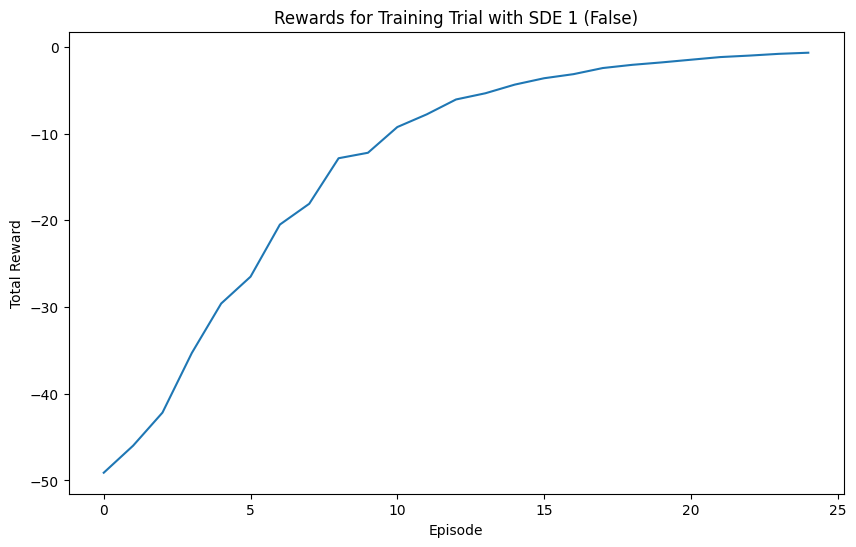

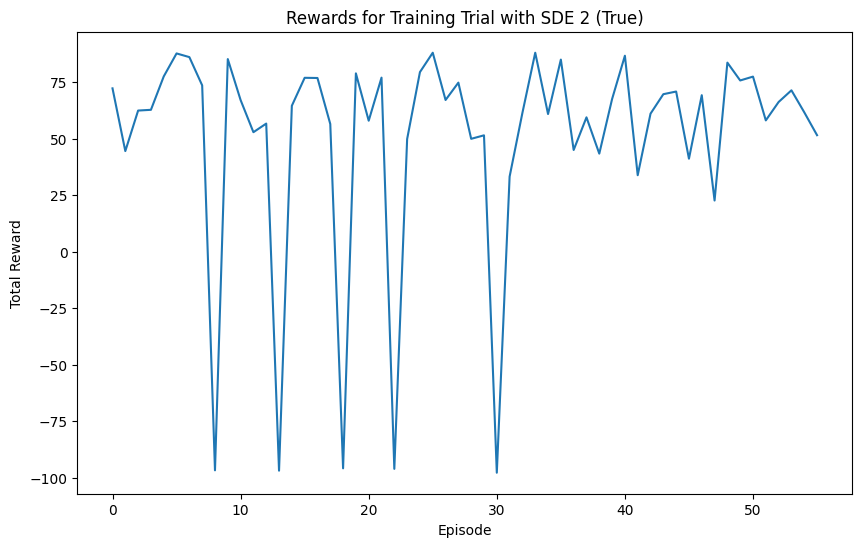

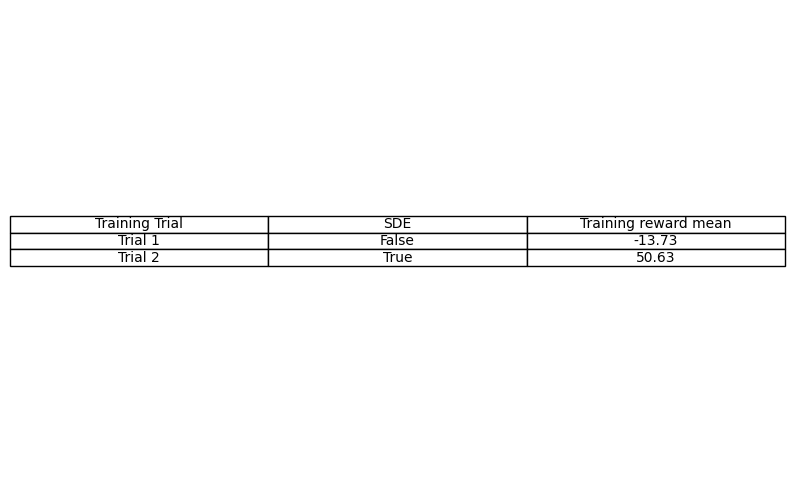

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial with SDE {i+1} ({sdes[i]})")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", sdes[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "SDE", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
Like the PPO, we observe that in the first plot without the SDE mechanism, the training is stable, but the agent won't explore enough, as we saw in earlier experiments, so the agent fails to learn the optimal policy and stabilises near 0. In the second graph with SDE, the agent seems to explore the environment and improve generally, but not with a stable training phase, ~50 reward mean.

### Entropy Coefficient Analysis

The **entropy coefficient** $c_2$ controls the weight of the entropy term in the A2C loss function. Entropy measures the randomness in the agent's action distribution. Adding an entropy bonus encourages the agent to explore more by preventing the policy from becoming overly deterministic early in training. For testing this hyperparameter, I will use 100k total timesteps.

---

**Full Objective Function:**

$
L^{\text{A2C}}_t(\theta, \phi) = \widehat{\mathbb{E}}_t \left[ L^{\text{PG}}_t(\theta) - c_1 L^{\text{VF}}_t(\phi) + c_2 S[\pi_\theta](s_t) \right]
$

- $
  L^{\text{PG}}_t(\theta) = -\widehat{\mathbb{E}}_t \left[ \log \pi_\theta(a_t | s_t) \widehat{A}_t \right]
$

- $
  L^{\text{VF}}_t(\phi) = \widehat{\mathbb{E}}_t \left[ \left( V_\phi(s_t) - V^{\text{target}}_t \right)^2 \right]
$

- $
  S[\pi_\theta](s_t) = \frac{1}{2} \log(2\pi e \sigma^2)
$

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
ent_coefs = [1e-3, 1e-2, 1e-1]
all_rewards = []
trial_rew_mean = []


for ent_coef in ent_coefs:

  #Training trials with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ent_coef} Entropy coefficient")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=7e-4,                                             # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=1,                                                   # GAE lambda
      ent_coef=ent_coef,                                              # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      rms_prop_eps=1e-05,                                             # RMSProp epsilon
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=0,                                                        # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with 0.001 Entropy coefficient
All episodes: 55

Training with 0.01 Entropy coefficient
All episodes: 59

Training with 0.1 Entropy coefficient
All episodes: 60
Model A2C_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

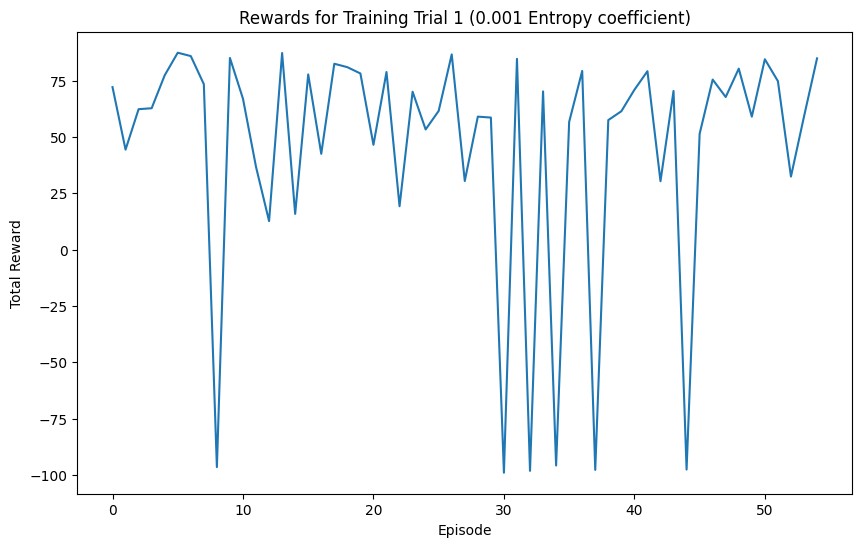

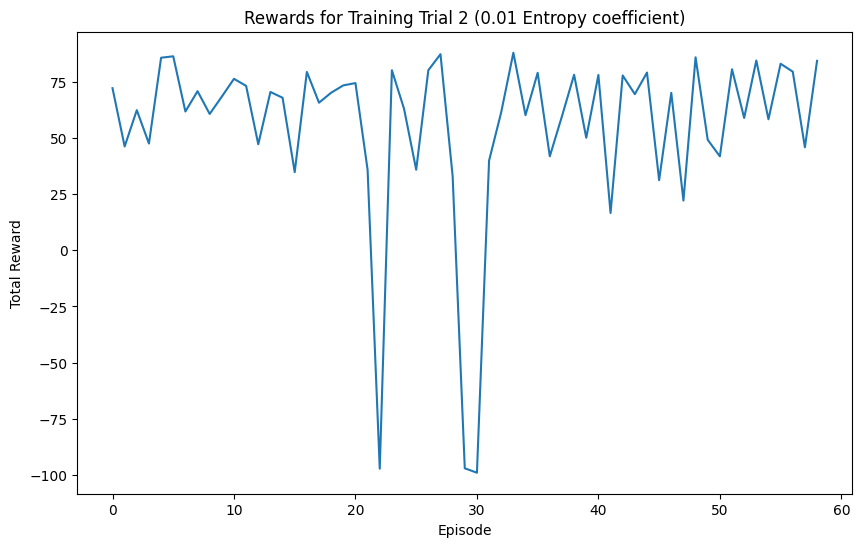

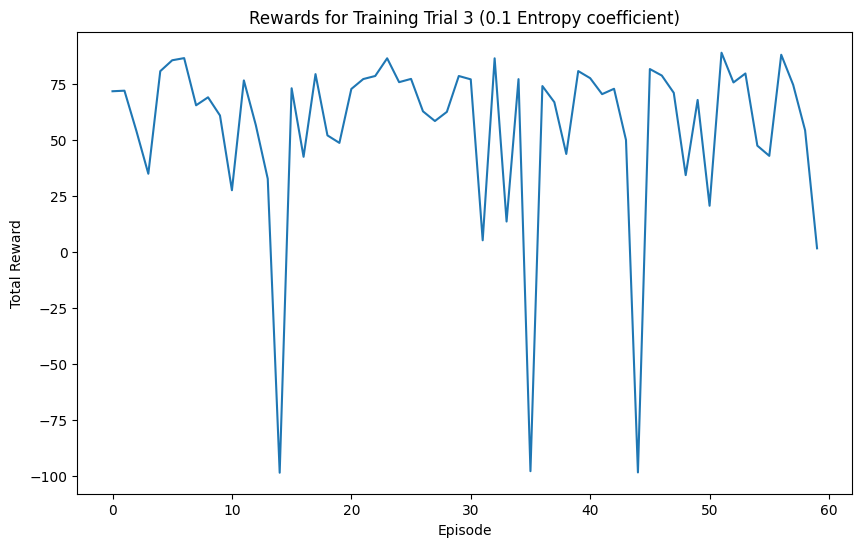

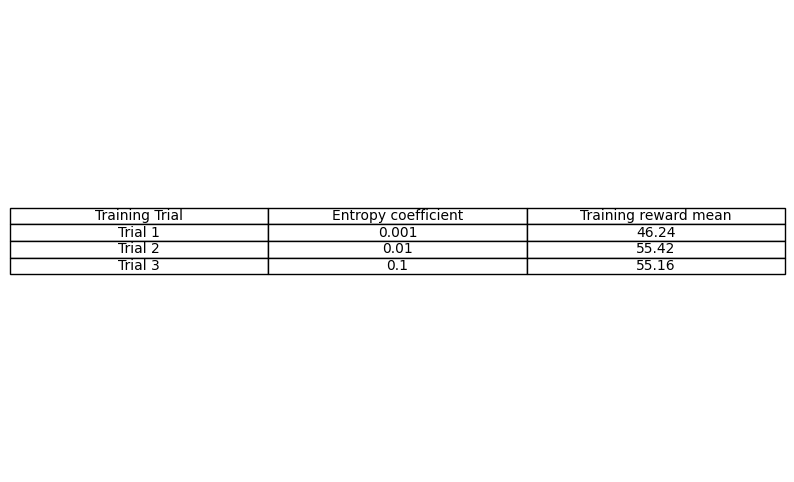

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ent_coefs[i]} Entropy coefficient)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ent_coefs[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Entropy coefficient", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
Using higher entropy coefficients (0.01 and 0.1) during the three trials led to higher average rewards than the lowest entropy (0.001). Trial 1 had a lower mean reward than Trials 2 and 3, which reached a mean of about 55. While all trials show fluctuations and dips into negative rewards, the trials with higher entropy coefficients often rebounded quickly and maintained higher peaks. This shows us that increasing entropy (encouraging more exploration) may help the policy escape local minima in the environment.

### Learning Rate Analysis

The learning rate is a hyperparameter that controls the step size of the gradient updates for both the policy and value networks, which share the same optimizer. By default, A2C uses the RMSProp optimizer with a learning rate of 7e-4. For testing this hyperparameter, I will use 100k total timesteps.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
ln_rates = [7e-6, 7e-5, 7e-4]
all_rewards = []
trial_rew_mean = []


for ln_rate in ln_rates:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {ln_rate} Learning Rate")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=ln_rate,                                          # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=1,                                                   # GAE lambda
      ent_coef=0.1,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.5,                                              # Gradient clipping
      rms_prop_eps=1e-05,                                             # RMSProp epsilon
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=0,                                                         # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with 7e-06 Learning Rate
All episodes: 33

Training with 7e-05 Learning Rate
All episodes: 51

Training with 0.0007 Learning Rate
All episodes: 60
Model A2C_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

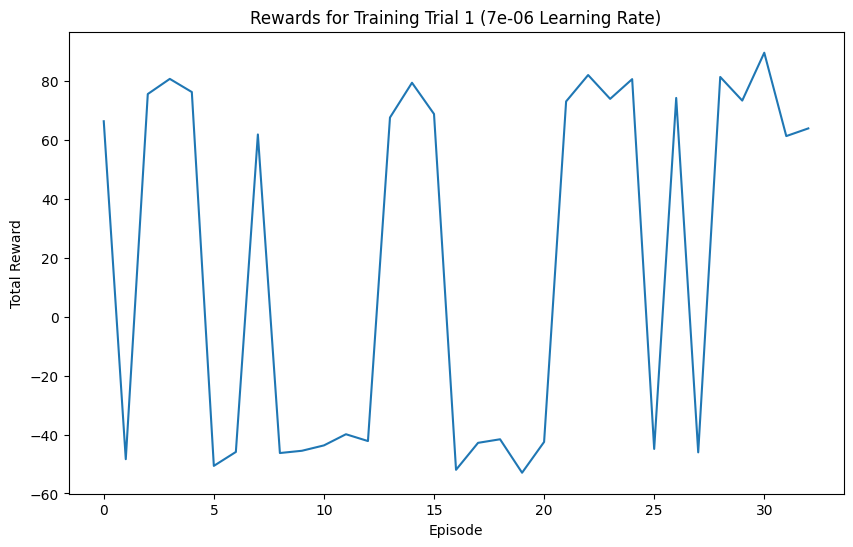

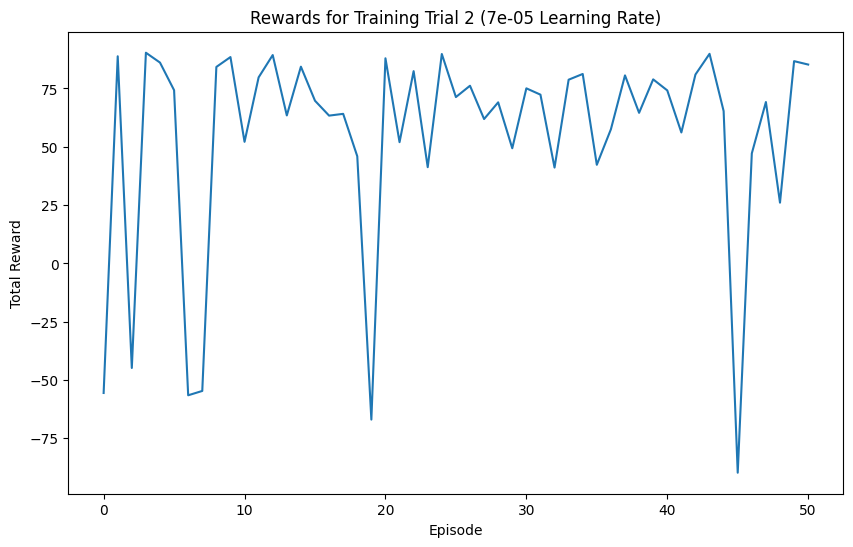

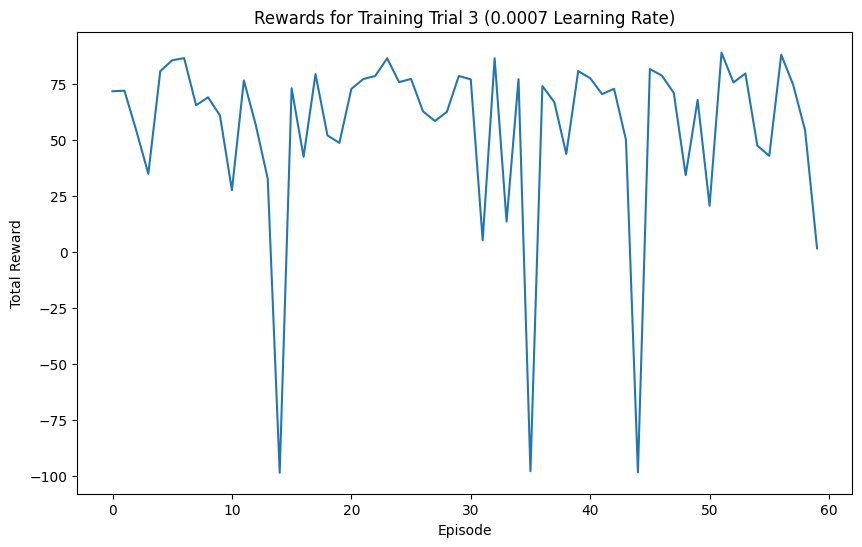

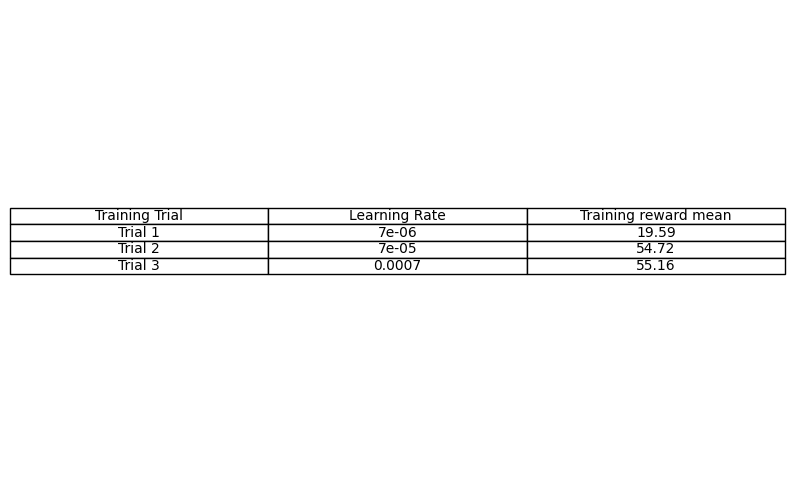

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({ln_rates[i]} Learning Rate)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", ln_rates[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Learning Rate", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
With the smallest learning rate (7e-6), the model struggled to improve and ended with an average reward around 19.59. The higher learning rates (7e-5 and 7e-4) both showed better outcomes, reaching average rewards of ~55, meaning that a slightly faster learning rate helped the agent converge to a more effective policy. The reward curves show some volatility early in training, but the model generally stabilizes to higher reward levels for the larger learning rates. This shows us that even small changes in learning rate can lead to big differences in final performance.

### GAE λ Analysis

In A2C, the GAE λ parameter controls how much weight is placed on higher-order returns when computing the advantage estimate. Generalized Advantage Estimation combines multiple-step returns in a way that balances bias and variance, a smaller gae_lambda puts more emphasis on shorter horizons (lower bias but higher variance), while a higher emphasis on longer horizons (higher bias but lower variance). If GAE λ=1 we have the default functionality of n-step advantage approach that relies fully on the multi-step returns rather than decaying their weight.


In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
gae_lambdas = [0.5, 0.65, 0.8, 0.9, 1]
all_rewards = []
trial_rew_mean = []


for gae_lambda in gae_lambdas:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with {gae_lambda} GAE λ ")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=7e-4,                                             # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=gae_lambda,                                          # GAE lambda
      ent_coef=0.1,                                                  # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.7,                                              # Gradient clipping
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=0,                                                         # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=100_000, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with 0.5 GAE λ 
All episodes: 71

Training with 0.65 GAE λ 
All episodes: 69

Training with 0.8 GAE λ 
All episodes: 61

Training with 0.9 GAE λ 
All episodes: 65

Training with 1 GAE λ 
All episodes: 57
Model A2C_MLP saved successfully.


<Figure size 1000x600 with 0 Axes>

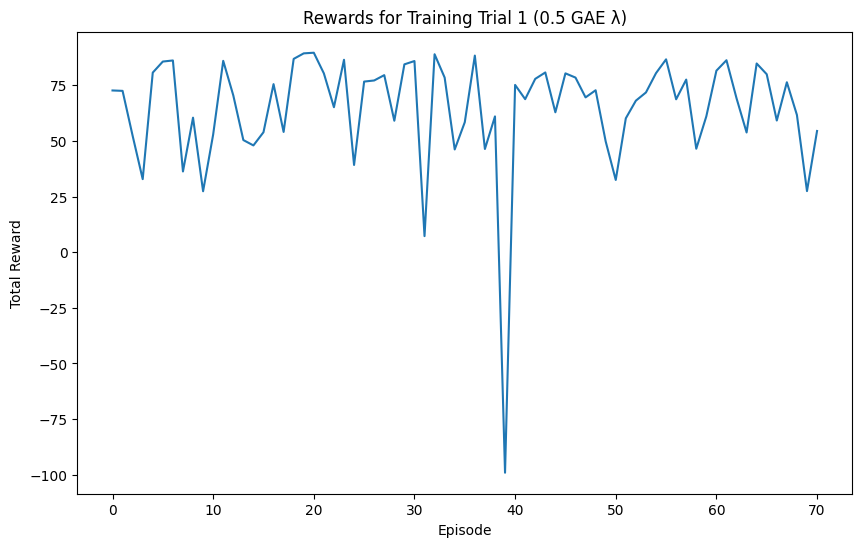

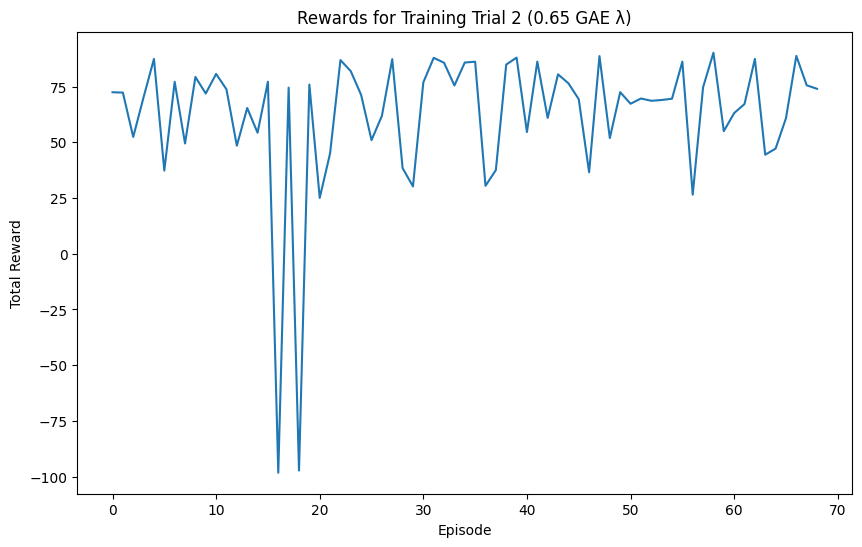

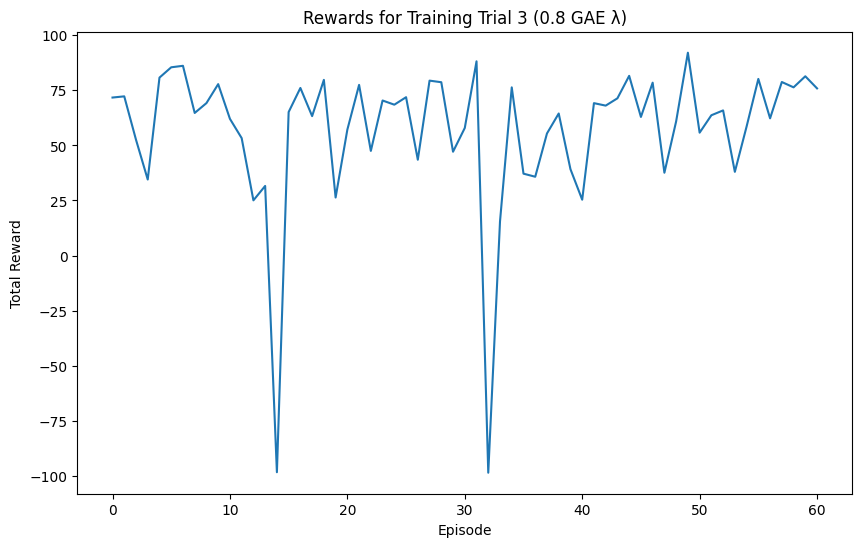

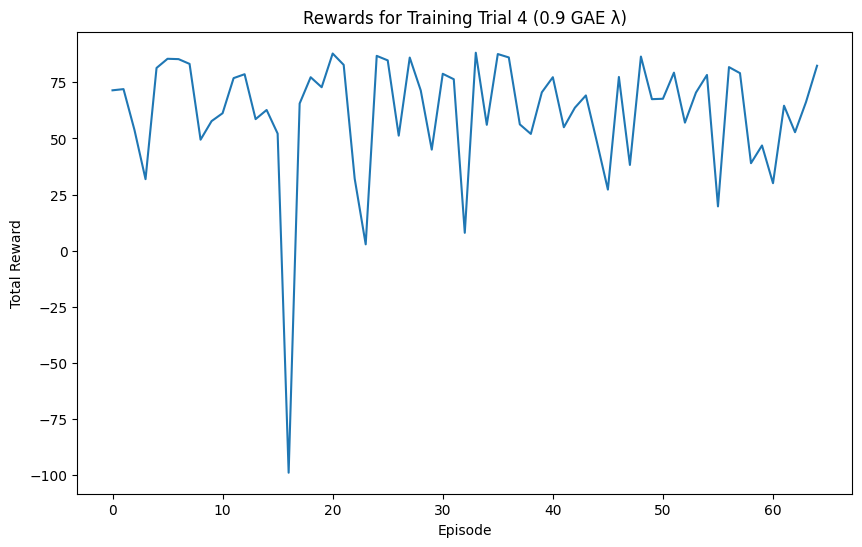

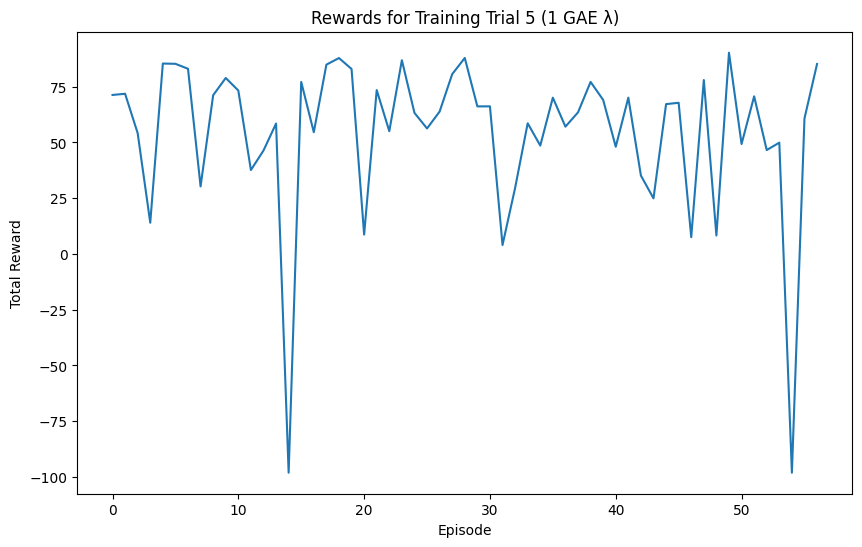

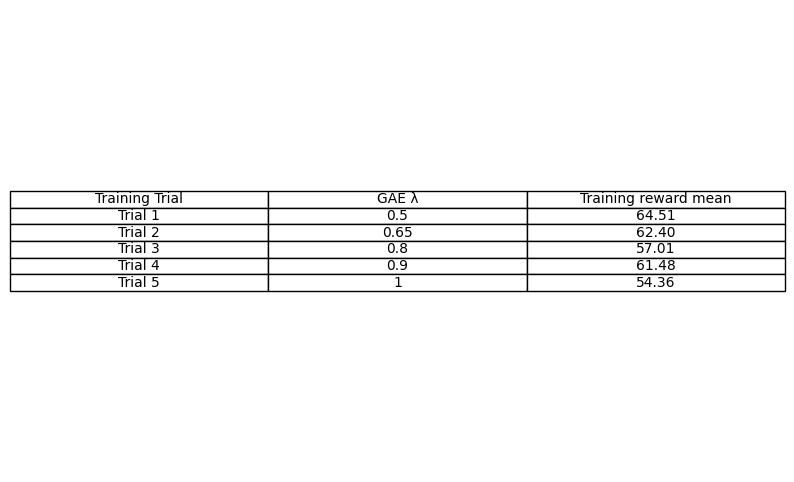

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({gae_lambdas[i]} GAE λ)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", gae_lambdas[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "GAE λ", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
Here we see that λ = 0.5 showed the highest mean return (64.51), while λ = 1.0 ended up with the lowest mean (54.36). This suggests that in this environment, having more weight on shorter returns (lower λ) may offer better performance. The training curves also show that all trials have some volatility, dropping to low or negative returns, but they generally recover to the prior reward levels by the end of training. In this environment, a smaller λ (higher variance) appears to be better for advantage estimation.

### Seeding

Here I will test the algorithm with different seeds to showcase the importance of seeding. Seeding controls the initialization of randomness in training processes, ensuring reproducibility by fixing the random number generators for neural network weights, environment dynamics, and exploration noise.

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
seeds = [0, 5, 10, 25, 42, 50]
all_rewards = []
trial_rew_mean = []


for seed in seeds:

  # Training trial with different hyper parameters
  logger_callback.episode_rewards = []
  print(f"\nTraining with Seed={seed} ")

  model = A2C(
      "MlpPolicy",
      env,
      learning_rate=7e-4,                                             # Change the learning rate
      n_steps=5,                                                      # Steps per rollout
      gae_lambda=0.5,                                                 # GAE lambda
      ent_coef=0.1,                                                   # Entropy coefficient
      vf_coef=0.5,                                                    # Value function coefficient
      max_grad_norm=0.7,                                              # Gradient clipping
      use_rms_prop=True,                                              # Rmsprop or Adam
      use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
      seed=seed,                                                      # Seeding
      verbose=0,                                                      # Verbosity level
      device='cpu'                                                    # Device
  )

  # Train the model with the callback
  model.learn(total_timesteps=timestep, callback=logger_callback)

  # Store the rewards from this session
  all_rewards.append(logger_callback.episode_rewards)

  # Compute the ep_rew_mean
  ep_rew_mean = np.mean(logger_callback.episode_rewards)
  trial_rew_mean.append(ep_rew_mean)

  print("All episodes:", len(logger_callback.episode_rewards))


# Save the trained model
model.save("A2C_MLP")
env.close()
print("Model A2C_MLP saved successfully.")


Training with Seed=0 
All episodes: 132

Training with Seed=5 
All episodes: 115

Training with Seed=10 
All episodes: 112

Training with Seed=25 
All episodes: 112

Training with Seed=42 
All episodes: 122

Training with Seed=50 
All episodes: 120
Model A2C_MLP saved successfully.


#### Total Rewards Plot

<Figure size 1000x600 with 0 Axes>

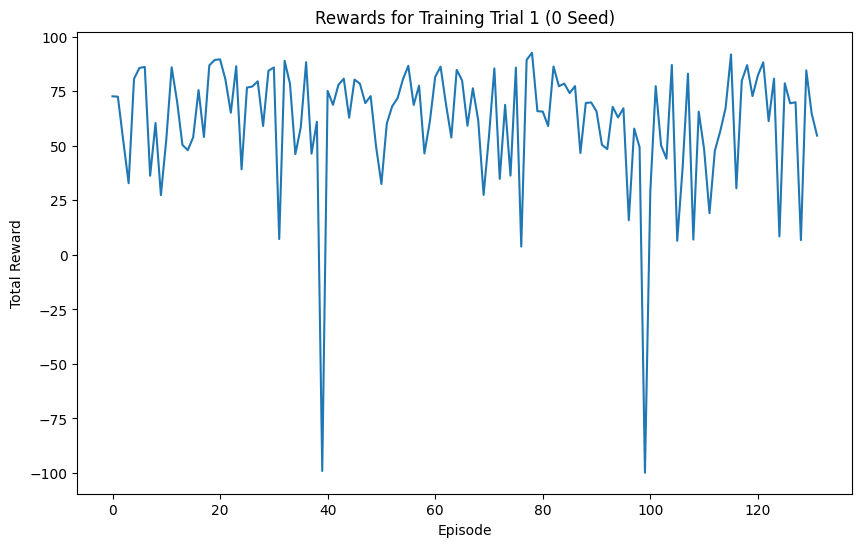

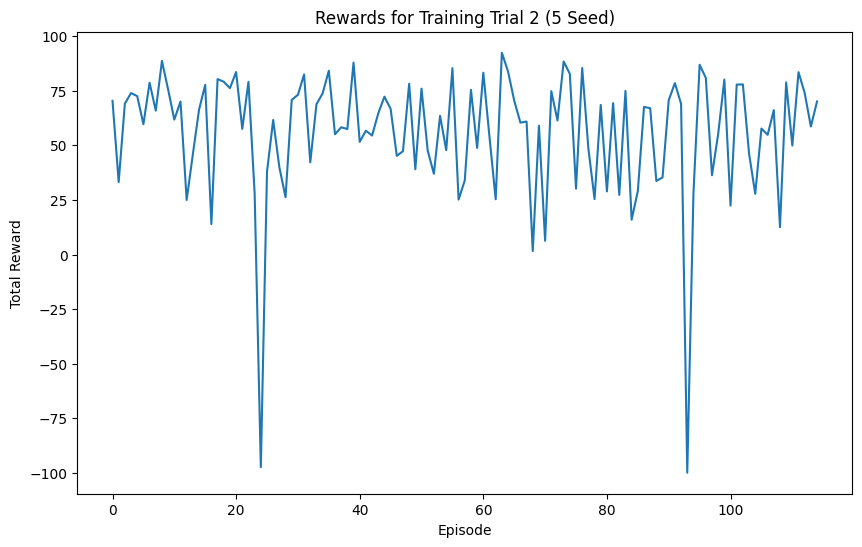

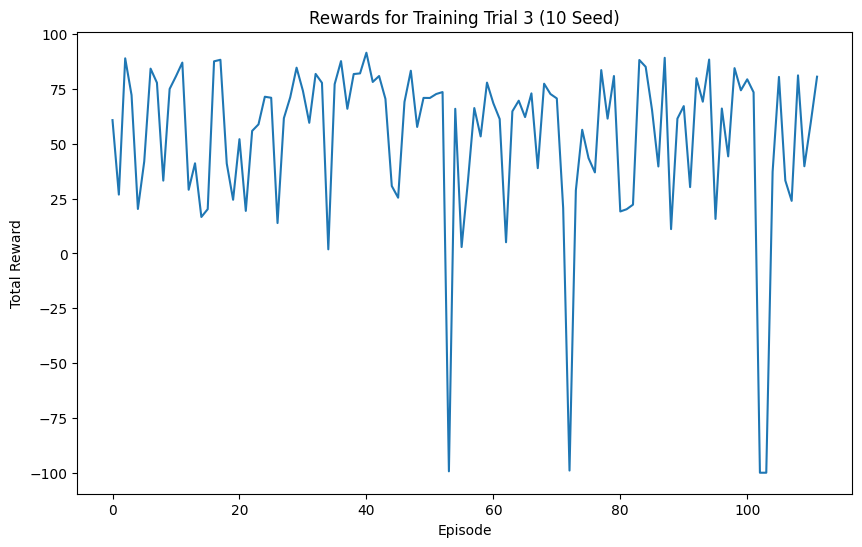

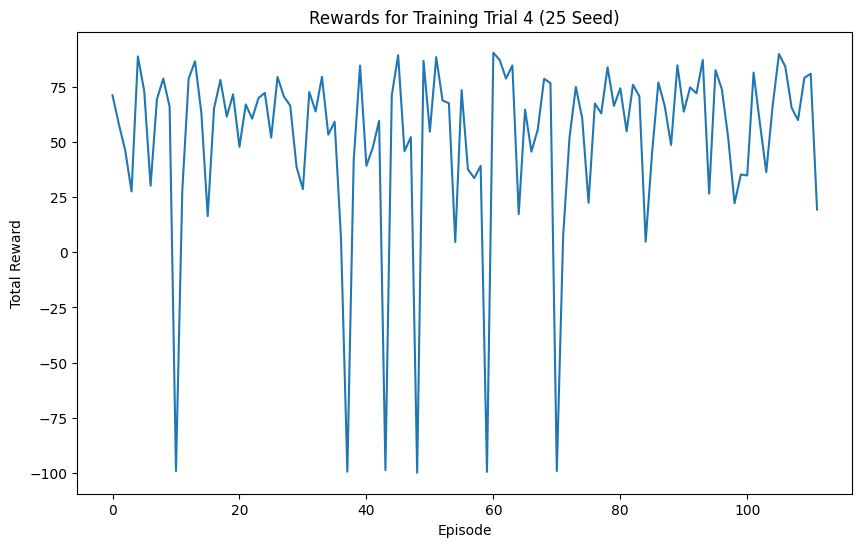

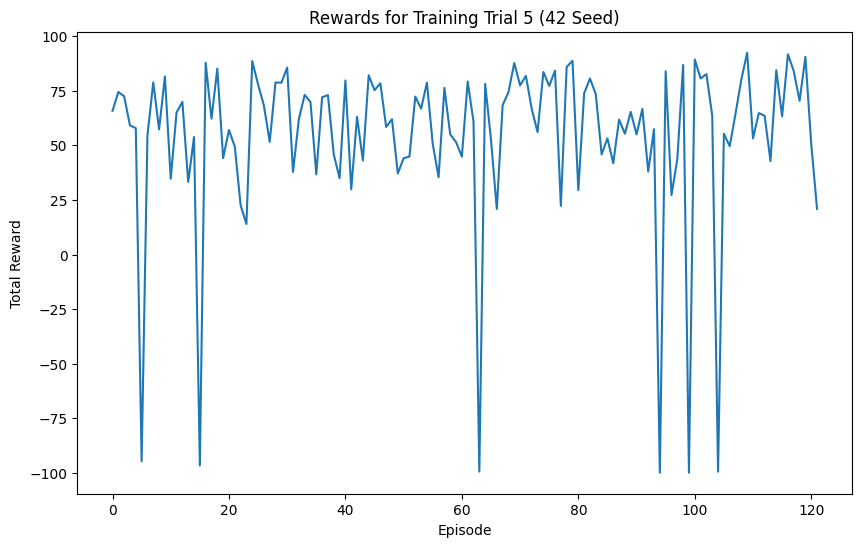

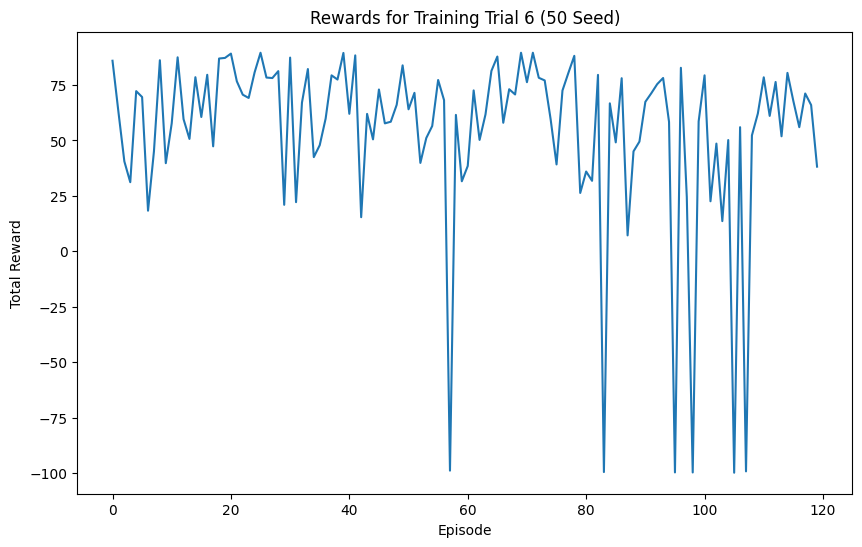

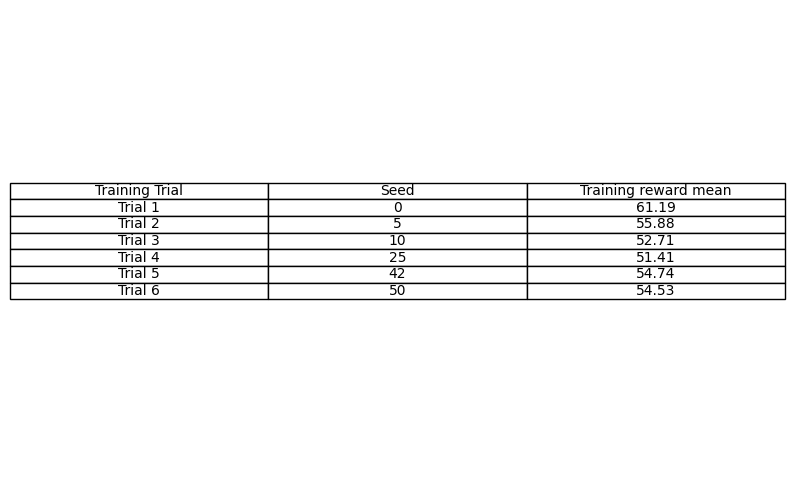

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
for i, rewards in enumerate(all_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Rewards for Training Trial {i+1} ({seeds[i]} Seed)")
    plt.show()

# Matrix showing training trial reward mean
plt.figure(figsize=(10, 6))
plt.axis('off')
plt.table(cellText=[[f"Trial {i+1}", seeds[i], f"{trial_rew_mean[i]:.2f}"] for i in range(len(trial_rew_mean))],
          colLabels=["Training Trial", "Seed", "Training reward mean"], loc='center', cellLoc='center')
plt.show()

#### Observations
The training shows less variability (from PPO) in performance across different seeds, with Trial 1 (seed=0) achieving the highest mean reward (61.19), while the rest trials (in the range 50-55) show lower mean rewards but not with significant differences. This suggests low sensitivity to initialization. The average rewards range from about 51 to 61, showing that while the agent learns a successful policy, its final performance can vary by 10 points depending on the seed. With that in mind for the scope of our project, seed 0 will be used as optimal and seed 25 as the worst.

### Conclusion

In MountainCar continuous, you only get a positive reward when you reach the top, with the A2C algorithm, that means that we will have a sparse reward problem(just like the PPO algorithm previously). A2C is an on-policy algorithm, it performs a policy gradient update after each episode. Reaching the goal in MountainCar by random actions is a pretty rare event. When it finally happens, it's very unlikely that a single policy gradient update will be enough to start reaching the goal consistently, so A2C gets stuck again with no learning signal until it reaches the goal again by chance.

In conclusion, the experiments show that both A2C and PPO algorithms tend to plateau at suboptimal reward levels when exploration is limited, with agents often converging around 0 despite occasional improvement. When using mechanisms such as SDE and higher entropy coefficients the exploration gets improved, allowing the policy to escape local minima and achieve higher mean rewards, up to approximately 55, with the optimal configuration reaching around 64.51 when using a lower λ for advantage estimation. Also, the results show that even slight increases in learning rate can improve performance, while seed variability plays a minor role, affecting mean rewards by roughly 10 points. Overall, these findings show us that the balance between exploration and exploitation is important and the sensitivity of performance for the hyperparameter tuning is something of great consideration.

## A2C Optimal Model

In [ ]:
# Create the callback
logger_callback = EpisodeLoggerCallback()
trial_rew_mean = []

# Create and train the A2C model in parallel enviroments
num_envs = 4
env = DummyVecEnv([
    lambda: Monitor(gym.make("MountainCarContinuous-v0", render_mode="rgb_array"))
    for _ in range(num_envs)
])
logger_callback.episode_rewards = []

model = A2C(
    "MlpPolicy",
    env,
    learning_rate=7e-4,                                             # Change the learning rate
    n_steps=5,                                                      # Steps per rollout
    gae_lambda=0.5,                                                 # GAE lambda
    ent_coef=0.1,                                                   # Entropy coefficient
    vf_coef=0.5,                                                    # Value function coefficient
    max_grad_norm=0.7,                                              # Gradient clipping
    use_rms_prop=True,                                              # Rmsprop or Adam
    use_sde=True,                                                   # Use generalized State Dependent Exploration (gSDE)
    seed=0,                                                         # Seeding
    verbose=0,                                                      # Verbosity level
    device='cpu'                                                    # Device
)

# Train the model with the callback
model.learn(total_timesteps=100_000, callback=logger_callback)
rewards = logger_callback.episode_rewards

# Compute the ep_rew_mean
ep_rew_mean = np.mean(logger_callback.episode_rewards)
trial_rew_mean.append(ep_rew_mean)

print("All episodes :", len(logger_callback.episode_rewards))
model1_rewards = logger_callback.episode_rewards[:]
model1_mean = np.mean(model1_rewards)


# Save the trained model
model.save("A2C_MLP_Opt1")
env.close()
print("Model A2C_MLP_Opt1 saved successfully.")

All episodes : 71
Model A2C_MLP_Opt1 saved successfully.


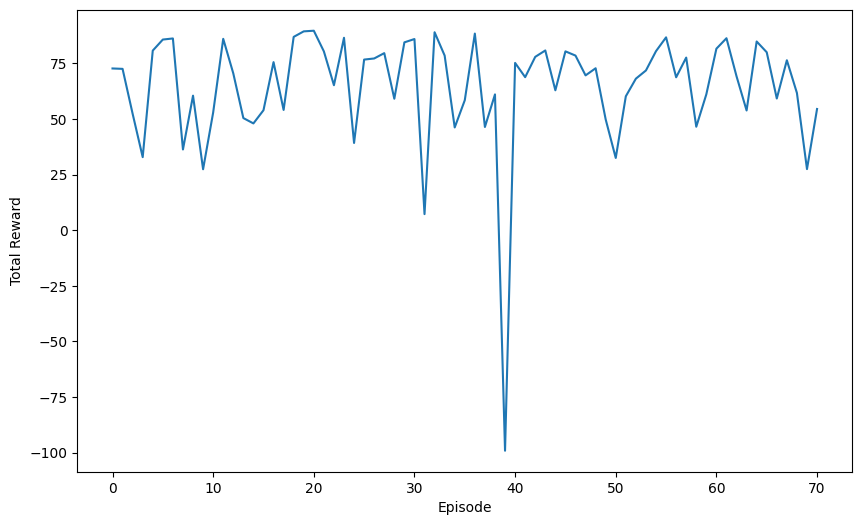

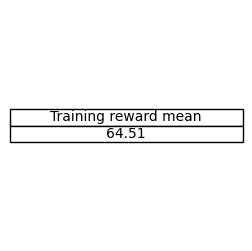

In [ ]:
# Plot rewards for all training trials
plt.figure(figsize=(10, 6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.table(
    cellText=[[f"{ep_rew_mean:.2f}"]],
    colLabels=["Training reward mean"],loc='center',cellLoc='center'
)
plt.show()